In [1]:
!cp /kaggle/input/nn-utils/* .

In [2]:
!cp /kaggle/input/nn-train-v4/model.weights.h5 .

In [3]:
!pip install tensorflow==2.18.0 keras h5py keras==3.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 377.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 4.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.18.0 wh

In [4]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from MultiTimeframeCandleManager import *
from datetime import datetime, timedelta
import time
from collections import deque
import numpy as np
import copy
import tensorflow as tf
from tqdm import tqdm
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt

#candles = obj_load("/content/NQ_2")[-100000:]
candles = obj_load("/kaggle/input/us-futures-1-minute-candlesticks/NQ_1")#[50000:]
len(candles)

loading /kaggle/input/us-futures-1-minute-candlesticks/NQ_1


99990

In [5]:
lrelu = tf.keras.layers.LeakyReLU(0.05)


chart_m15 = tf.keras.layers.Input(shape = (60,4))
chart_m15 = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, -1000.0, 1000.0))(chart_m15)

chart_m5 = tf.keras.layers.Input(shape = (60,4))
chart_m5 = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, -1000.0, 1000.0))(chart_m5)

chart_m1 = tf.keras.layers.Input(shape = (60,4))
chart_m1 = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, -1000.0, 1000.0))(chart_m1)

pdas = tf.keras.layers.Input(shape = (3*3+3*3+1+12*5+5*3,))

pdas_repeated = tf.keras.layers.Lambda(
lambda inputs: tf.repeat(tf.expand_dims(inputs, axis = 1), repeats=60, axis=1)
)(pdas)

concatenated_m15_at = tf.keras.layers.Concatenate(axis=-1)([chart_m15, pdas_repeated])
m15_at = tf.keras.layers.Dense(1024)(concatenated_m15_at)
m15_at = lrelu(m15_at)
m15_at = tf.keras.layers.Dense(512)(m15_at)
m15_at = lrelu(m15_at)
m15_at = tf.keras.layers.Dense(512)(m15_at)
m15_at = lrelu(m15_at)
m15_at = tf.keras.layers.Dense(512)(m15_at)
#m15_at = tf.keras.layers.LayerNormalization()(m15_at)
m15_at = lrelu(m15_at)
m15_at = tf.keras.layers.LSTM(1024, return_sequences=True)(m15_at)
m15_at = tf.keras.layers.LSTM(1024, return_sequences=False)(m15_at)

concatenated_m5_at = tf.keras.layers.Concatenate(axis=-1)([chart_m5, pdas_repeated])
m5_at = tf.keras.layers.Dense(1024)(concatenated_m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(512)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(512)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(512)(m5_at)
#m5_at = tf.keras.layers.LayerNormalization()(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.LSTM(1024, return_sequences=True)(m5_at)
m5_at = tf.keras.layers.LSTM(1024, return_sequences=False)(m5_at)

concatenated_m1_at = tf.keras.layers.Concatenate(axis=-1)([chart_m1, pdas_repeated])
m1_at = tf.keras.layers.Dense(1024)(concatenated_m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(512)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(512)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(512)(m1_at)
#m1_at = tf.keras.layers.LayerNormalization()(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.LSTM(1024, return_sequences=True)(m1_at)
m1_at = tf.keras.layers.LSTM(1024, return_sequences=False)(m1_at)

minutes = tf.keras.layers.Input(shape = (1,))
minutes_embed = tf.keras.layers.Embedding(input_dim=60*24, output_dim=8)(minutes)
minutes_embed_flat = tf.keras.layers.Flatten()(minutes_embed)

f15 = tf.keras.layers.Flatten()(chart_m15)
f5 = tf.keras.layers.Flatten()(chart_m5)
f1 = tf.keras.layers.Flatten()(chart_m1)

#c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, scaled_open_profit])
c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, m1_at, m5_at, m15_at])
#c = tf.keras.layers.Concatenate()([f1, pdas, minutes_embed_flat, m1_at, m5_at, m15_at])


d = tf.keras.layers.Dense(4096*4)(c)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)

d = tf.keras.layers.Dense(4096*4)(d)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)

d = tf.keras.layers.Dense(4096*2)(d)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)

d = tf.keras.layers.Dense(4096*2)(d)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)




output = tf.keras.layers.Dense(3, activation="softmax", dtype="float32")(d)

model = tf.keras.Model(inputs = [chart_m15, chart_m5, chart_m1, pdas, minutes], outputs = output)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001, clipnorm=1.0)


model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 94)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ keras_tensor_11CLONE      │ (None, 60, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 60, 94)         │              0 │ input_layer_3[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 60, 98)         │              0 │ keras_tensor_11CLONE[… │
│ (Concatenate)             │                        │                │ lambda_3[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 60, 1024)       │        101,376 │ concatenate_2[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 8192)           │              0 │ dense_8[1][0],         │
│                           │                        │                │ dense_9[1][0],         │
│                           │                        │                │ dense_10[1][0],        │
│                           │                        │                │ dense_11[1][0],        │
│                           │                        │                │ dense_4[1][0],         │
│                           │                        │                │ dense_5[1][0],         │
│                           │                        │                │ dense_6[1][0],         │
│                           │                        │                │ dense_7[1][0],         │
│                           │                        │                │ dense[1][0],           │
│                           │                        │                │ dense_1[1][0],         │
│                           │                        │                │ dense_2[1][0],         │
│                           │                        │                │ dense_3[1][0],         │
│                           │                        │                │ dense_12[1][0],        │
│                           │                        │                │ dense_13[1][0],        │
│                           │                        │                │ dense_14[1][0],        │
│                           │                        │                │ dense_15[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 60, 512)        │        524,800 │ leaky_re_lu[16][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ keras_tensor_7CLONE       │ (None, 60, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 60, 512)        │        262,656 │ leaky_re_lu[17][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 60, 98)         │              0 │ keras_tensor_7CLONE[1… │
│ (Concatenate)        

 Total params: 581,165,827 (2.17 GB)

 Trainable params: 581,165,827 (2.17 GB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.load_weights("model.weights.h5")

In [7]:

class Order:
    def __init__(self, limit, stop, tp, direction):
        self.entry = limit
        self.tp = tp
        self.sl = stop
        self.direction = direction

class Position:
    def __init__(self, entry, stop, tp, direction):
        self.entry = entry
        self.tp = tp
        self.sl = stop
        self.direction = direction

In [8]:
def step(index):

        global current_position, current_order, slm, m, outputs, all_candles, cmm, equity, equity_L
    
        ret = m.push_m1_candle(candles[index])
        midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
        center = (midnight_opening_range_high + midnight_opening_range_low) / 2
        r = max(0.0001, (midnight_opening_range_high - midnight_opening_range_low) / 2)



        current_candle_m1 = charts[2][-1]
        #### check tp before filling order so that the same m1 candle will not trigger tp - it is not sure if the candle hit first limit and later tp or reve3rse
        if current_position.direction == 1:
            if current_candle_m1.h >= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.l <= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)

        #### check order
        if current_order != None:
            if  current_order.direction == 1:
                if current_candle_m1.l < current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill long order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None
        if current_order != None:
            if  current_order.direction == -1:
                if current_candle_m1.h > current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill short order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None

        #### check sl
        if current_position.direction == 1:
            if current_candle_m1.l <= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.h >= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)




        if(len(m.ndogs) == 5 and len(m.fps) == 3 and len(m.opening_range_gaps) == 3 and len(m.asia_highs_lows) == 3 and len(m.london_highs_lows) == 3 and len(m.ny_am_highs_lows) == 3 and len(m.ny_lunch_highs_lows) == 3 and len(m.ny_pm_highs_lows) == 3):


            open_profit = (current_close - current_position.entry) * current_position.direction

            scaled_entry_diff  =  0
            scaled_sl_diff  =  0
            if(current_position.direction != 0):
                scaled_entry_diff = (current_close - current_position.entry) / r
                scaled_sl_diff = (current_close - current_position.sl) / r

            state = ret_to_scaled_inputs(ret) + [np.array([current_position.direction, scaled_entry_diff, scaled_sl_diff])]
            m15_np, m5_np, m1_np, pda_np, current_minutes, pos_info = state

            equity_L.append(equity+open_profit)
            all_candles.append(charts[2][-1])


            if True:#current_minutes >= 9*60+29 and current_minutes < 16*60:
                output = inference_step(
                    tf.expand_dims(m15_np, 0),
                    tf.expand_dims(m5_np, 0),
                    tf.expand_dims(m1_np, 0),
                    tf.expand_dims(pda_np, 0),
                    tf.expand_dims(current_minutes, 0),
                    #tf.expand_dims(pos_info, 0)
                )

              
                last_action = np.argmax(output)
                #last_action = np.argmax([output[0][0], output[0][1]])
                outputs.append(output[0])
            else:
                last_action = 2


            avg_candle_range = np.mean([ i.h - i.l for i in list(charts[2])])

            if(last_action == 2):
                #equity += open_profit
                #current_position = Position(0,0,0,0)
                #print("close position:", open_profit)
                current_order = None

            if(last_action == 0 and current_position.direction == 1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 0):
                last_candle_low = charts[2][-2].l
                if ( last_candle_low < current_close ):
                    last_candle_low = None

                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[0] > current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1])
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0])

                if(len(pdas_filtered) > 2):

                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_low[0][0]
                    if(last_candle_low != None):
                        entry = min(entry, last_candle_low)


                    #sl = entry + avg_candle_range * slm
                    sl = sorted_by_low[2][1]
                    tp = entry  -  avg_candle_range * tpm

                    if current_position.direction == 0:
                        current_order = Order(entry, sl, tp, -1)
                        #print("set short order:",entry,sl,tp)
                    if current_position.direction == -1:
                        #current_position.sl = sl
                        current_position.tp = tp



            if(last_action == 1 and current_position.direction == -1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 1):
                last_candle_high = charts[2][-2].h
                if ( last_candle_high > current_close ):
                    last_candle_high = None
                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[1] < current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1], reverse=True)
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0], reverse=True)

                if(len(pdas_filtered) > 2):
                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_high[0][1]
                    if(last_candle_high != None):
                        entry = max(entry, last_candle_high)

                    #sl = entry - avg_candle_range * slm
                    sl = sorted_by_high[2][0]
                    tp = entry  +  avg_candle_range * tpm

                    if current_position.direction == 0:
                        current_order = Order(entry, sl, tp, 1)
                        #print("set long order:",entry,sl,tp)
                    if current_position.direction == 1:
                        #current_position.sl = sl
                        current_position.tp = tp
                        



In [9]:
m = MultiTimeframeCandleManager()

#slm = 2
#tpm = 6

slm = 2
tpm = 6


current_position = Position(0,0,0,0)
current_order = None

equity = 0
equity_L = [0]

outputs = []
all_candles = []

cmm = 0.5

@tf.function()
def inference_step(m15_np, m5_np, m1_np, pda_np, current_minutes):
    return model([
        m15_np,
        m5_np,
        m1_np,
        pda_np,
        current_minutes
    ])



#for index in tqdm(range(len(candles))):
for index in tqdm(range(len(candles))):
    step(index)
    if( index % 100 == 0 ):
        print("\n", equity_L[-1])

print(equity_L[-1])

  2%|▏         | 2364/99990 [00:00<00:04, 23635.91it/s]


 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0.0

 38.5


  5%|▍         | 4728/99990 [00:06<02:35, 613.52it/s]  


 -25.5

 -23.5

 -68.0

 4.75


  5%|▌         | 5113/99990 [00:20<08:58, 176.08it/s]


 17.0

 37.25

 122.75

 119.25

 -108.25


  6%|▌         | 5658/99990 [00:38<20:36, 76.31it/s]


 -108.25

 -108.25

 -59.75


  6%|▌         | 5984/99990 [00:50<28:34, 54.84it/s]


 -20.0

 67.77500000000146


  6%|▌         | 6196/99990 [00:57<34:31, 45.27it/s]


 37.775000000001455

 63.275000000001455


  6%|▋         | 6337/99990 [01:02<38:03, 41.01it/s]


 18.275000000001455


  7%|▋         | 6500/99990 [01:07<42:10, 36.95it/s]


 38.525000000001455


  7%|▋         | 6604/99990 [01:11<45:24, 34.28it/s]


 187.27500000000146


  7%|▋         | 6704/99990 [01:14<53:24, 29.11it/s]


 191.52500000000146


  7%|▋         | 6806/99990 [01:18<54:03, 28.73it/s]


 228.57500000000073


  7%|▋         | 6905/99990 [01:21<54:28, 28.48it/s]


 206.57500000000073


  7%|▋         | 7004/99990 [01:25<54:18, 28.53it/s]


 278.0750000000007


  7%|▋         | 7106/99990 [01:28<54:01, 28.65it/s]


 322.8250000000007


  7%|▋         | 7205/99990 [01:32<54:04, 28.60it/s]


 376.90000000000146


  7%|▋         | 7304/99990 [01:35<54:13, 28.49it/s]


 466.90000000000146


  7%|▋         | 7406/99990 [01:39<53:55, 28.61it/s]


 473.65000000000146


  8%|▊         | 7505/99990 [01:42<53:54, 28.59it/s]


 399.15000000000146


  8%|▊         | 7604/99990 [01:46<53:19, 28.88it/s]


 397.90000000000146


  8%|▊         | 7706/99990 [01:49<53:16, 28.87it/s]


 389.65000000000146


  8%|▊         | 7805/99990 [01:53<53:13, 28.87it/s]


 401.65000000000146


  8%|▊         | 7904/99990 [01:56<53:09, 28.87it/s]


 440.4250000000029


  8%|▊         | 8006/99990 [02:00<53:25, 28.69it/s]


 477.6750000000029


  8%|▊         | 8105/99990 [02:03<53:38, 28.55it/s]


 494.95000000000437


  8%|▊         | 8204/99990 [02:07<53:11, 28.76it/s]


 545.7000000000044


  8%|▊         | 8306/99990 [02:10<52:42, 28.99it/s]


 699.2000000000044


  8%|▊         | 8405/99990 [02:14<52:46, 28.93it/s]


 572.7000000000044


  9%|▊         | 8504/99990 [02:17<52:42, 28.93it/s]


 572.7000000000044


  9%|▊         | 8606/99990 [02:21<52:21, 29.09it/s]


 583.2000000000044


  9%|▊         | 8705/99990 [02:24<52:36, 28.92it/s]


 605.9500000000044


  9%|▉         | 8804/99990 [02:27<52:35, 28.90it/s]


 605.2000000000044


  9%|▉         | 8906/99990 [02:31<52:37, 28.85it/s]


 577.4500000000044


  9%|▉         | 9005/99990 [02:34<52:11, 29.05it/s]


 588.7000000000044


  9%|▉         | 9104/99990 [02:38<53:09, 28.50it/s]


 584.9500000000044


  9%|▉         | 9206/99990 [02:41<52:16, 28.94it/s]


 565.9500000000044


  9%|▉         | 9305/99990 [02:45<52:20, 28.88it/s]


 556.4500000000044


  9%|▉         | 9404/99990 [02:48<51:57, 29.06it/s]


 550.9500000000044


 10%|▉         | 9506/99990 [02:52<52:04, 28.96it/s]


 537.9500000000044


 10%|▉         | 9605/99990 [02:55<52:36, 28.63it/s]


 489.95000000000437


 10%|▉         | 9704/99990 [02:59<52:01, 28.92it/s]


 447.45000000000437


 10%|▉         | 9806/99990 [03:02<51:46, 29.03it/s]


 398.70000000000437


 10%|▉         | 9905/99990 [03:05<51:57, 28.90it/s]


 388.95000000000437


 10%|█         | 10004/99990 [03:09<51:58, 28.85it/s]


 380.20000000000437


 10%|█         | 10106/99990 [03:12<51:51, 28.89it/s]


 369.95000000000437


 10%|█         | 10205/99990 [03:16<51:41, 28.95it/s]


 385.45000000000437


 10%|█         | 10304/99990 [03:19<51:33, 28.99it/s]


 404.20000000000437


 10%|█         | 10406/99990 [03:23<51:26, 29.03it/s]


 512.5750000000044


 11%|█         | 10505/99990 [03:26<51:57, 28.70it/s]


 543.4750000000058


 11%|█         | 10604/99990 [03:30<51:22, 29.00it/s]


 543.4750000000058


 11%|█         | 10706/99990 [03:33<51:46, 28.74it/s]


 543.4750000000058


 11%|█         | 10805/99990 [03:37<50:34, 29.39it/s]


 494.7250000000058


 11%|█         | 10904/99990 [03:40<51:19, 28.93it/s]


 494.7250000000058


 11%|█         | 11006/99990 [03:44<51:20, 28.89it/s]


 554.7250000000058


 11%|█         | 11105/99990 [03:47<51:09, 28.95it/s]


 547.2250000000058


 11%|█         | 11204/99990 [03:50<51:06, 28.95it/s]


 584.9750000000058


 11%|█▏        | 11306/99990 [03:54<51:31, 28.69it/s]


 613.4750000000058


 11%|█▏        | 11405/99990 [03:57<51:58, 28.41it/s]


 618.7250000000058


 12%|█▏        | 11504/99990 [04:01<50:56, 28.95it/s]


 627.9750000000058


 12%|█▏        | 11606/99990 [04:04<51:28, 28.62it/s]


 638.7250000000058


 12%|█▏        | 11705/99990 [04:08<50:59, 28.85it/s]


 645.1000000000058


 12%|█▏        | 11804/99990 [04:11<51:01, 28.81it/s]


 665.1000000000058


 12%|█▏        | 11906/99990 [04:15<50:35, 29.02it/s]


 652.6000000000058


 12%|█▏        | 12005/99990 [04:18<50:36, 28.98it/s]


 637.3500000000058


 12%|█▏        | 12104/99990 [04:22<50:36, 28.94it/s]


 708.8500000000058


 12%|█▏        | 12206/99990 [04:25<50:31, 28.96it/s]


 1017.8500000000058


 12%|█▏        | 12305/99990 [04:29<51:12, 28.54it/s]


 1028.8500000000058


 12%|█▏        | 12404/99990 [04:32<50:28, 28.92it/s]


 934.6000000000058


 13%|█▎        | 12506/99990 [04:35<50:30, 28.87it/s]


 1027.6000000000058


 13%|█▎        | 12605/99990 [04:39<50:13, 28.99it/s]


 1037.6000000000058


 13%|█▎        | 12704/99990 [04:42<50:30, 28.80it/s]


 1035.6000000000058


 13%|█▎        | 12806/99990 [04:46<50:20, 28.86it/s]


 1058.3500000000058


 13%|█▎        | 12905/99990 [04:49<50:39, 28.65it/s]


 1063.4500000000044


 13%|█▎        | 13004/99990 [04:53<50:00, 28.99it/s]


 1110.7000000000044


 13%|█▎        | 13106/99990 [04:56<50:27, 28.70it/s]


 1084.7000000000044


 13%|█▎        | 13205/99990 [05:00<49:52, 29.00it/s]


 1097.9500000000044


 13%|█▎        | 13304/99990 [05:03<50:26, 28.65it/s]


 1101.4500000000044


 13%|█▎        | 13406/99990 [05:07<49:57, 28.89it/s]


 1368.9750000000058


 14%|█▎        | 13505/99990 [05:10<55:58, 25.75it/s]


 1368.9750000000058


 14%|█▎        | 13604/99990 [05:14<49:44, 28.94it/s]


 1368.9750000000058


 14%|█▎        | 13706/99990 [05:17<49:48, 28.87it/s]


 1355.4750000000058


 14%|█▍        | 13805/99990 [05:21<50:13, 28.60it/s]


 1342.4750000000058


 14%|█▍        | 13904/99990 [05:24<49:49, 28.80it/s]


 1308.2250000000058


 14%|█▍        | 14006/99990 [05:27<49:22, 29.02it/s]


 1301.9750000000058


 14%|█▍        | 14105/99990 [05:31<49:35, 28.86it/s]


 1329.4750000000058


 14%|█▍        | 14204/99990 [05:34<49:17, 29.00it/s]


 1387.2250000000058


 14%|█▍        | 14306/99990 [05:38<49:29, 28.85it/s]


 1389.9750000000058


 14%|█▍        | 14405/99990 [05:41<49:48, 28.63it/s]


 1388.7250000000058


 15%|█▍        | 14504/99990 [05:45<48:57, 29.11it/s]


 1376.7250000000058


 15%|█▍        | 14606/99990 [05:48<49:00, 29.04it/s]


 1368.4750000000058


 15%|█▍        | 14705/99990 [05:52<48:58, 29.02it/s]


 1353.7250000000058


 15%|█▍        | 14804/99990 [05:55<49:19, 28.78it/s]


 1380.9750000000058


 15%|█▍        | 14906/99990 [05:59<49:14, 28.80it/s]


 1547.7250000000058


 15%|█▌        | 15005/99990 [06:02<48:18, 29.32it/s]


 1716.4750000000058


 15%|█▌        | 15104/99990 [06:05<48:45, 29.01it/s]


 1857.4750000000058


 15%|█▌        | 15206/99990 [06:09<48:44, 28.99it/s]


 1857.4750000000058


 15%|█▌        | 15305/99990 [06:12<48:48, 28.92it/s]


 1925.8000000000065


 15%|█▌        | 15404/99990 [06:16<48:46, 28.90it/s]


 1965.025000000005


 16%|█▌        | 15506/99990 [06:19<48:27, 29.06it/s]


 1963.025000000005


 16%|█▌        | 15605/99990 [06:23<48:16, 29.13it/s]


 1950.525000000005


 16%|█▌        | 15704/99990 [06:26<48:10, 29.16it/s]


 1922.025000000005


 16%|█▌        | 15806/99990 [06:30<48:00, 29.23it/s]


 1899.275000000005


 16%|█▌        | 15905/99990 [06:33<48:45, 28.74it/s]


 1904.025000000005


 16%|█▌        | 16004/99990 [06:36<48:04, 29.12it/s]


 1893.775000000005


 16%|█▌        | 16106/99990 [06:40<48:25, 28.87it/s]


 1908.025000000005


 16%|█▌        | 16205/99990 [06:43<48:07, 29.02it/s]


 2068.025000000005


 16%|█▋        | 16304/99990 [06:47<47:59, 29.06it/s]


 2385.275000000005


 16%|█▋        | 16406/99990 [06:50<48:05, 28.96it/s]


 2409.775000000005


 17%|█▋        | 16505/99990 [06:54<47:40, 29.19it/s]


 2357.775000000005


 17%|█▋        | 16604/99990 [06:57<47:37, 29.18it/s]


 2457.650000000005


 17%|█▋        | 16706/99990 [07:01<47:50, 29.01it/s]


 2479.400000000005


 17%|█▋        | 16805/99990 [07:04<47:33, 29.15it/s]


 2477.650000000005


 17%|█▋        | 16904/99990 [07:07<48:06, 28.79it/s]


 2454.650000000005


 17%|█▋        | 17006/99990 [07:11<47:32, 29.09it/s]


 2488.900000000005


 17%|█▋        | 17105/99990 [07:14<47:54, 28.83it/s]


 2463.900000000005


 17%|█▋        | 17204/99990 [07:18<46:54, 29.42it/s]


 2479.900000000005


 17%|█▋        | 17306/99990 [07:21<47:20, 29.11it/s]


 2445.900000000005


 17%|█▋        | 17405/99990 [07:25<47:20, 29.08it/s]


 2463.650000000005


 18%|█▊        | 17504/99990 [07:28<47:14, 29.11it/s]


 2481.900000000005


 18%|█▊        | 17606/99990 [07:32<47:23, 28.97it/s]


 2557.650000000005


 18%|█▊        | 17705/99990 [07:35<47:11, 29.07it/s]


 2467.400000000005


 18%|█▊        | 17804/99990 [07:38<47:39, 28.74it/s]


 2467.400000000005


 18%|█▊        | 17906/99990 [07:42<46:45, 29.26it/s]


 2475.150000000005


 18%|█▊        | 18005/99990 [07:45<46:27, 29.41it/s]


 2534.9250000000065


 18%|█▊        | 18104/99990 [07:49<46:26, 29.39it/s]


 2534.6750000000065


 18%|█▊        | 18206/99990 [07:52<46:39, 29.21it/s]


 2521.4250000000065


 18%|█▊        | 18305/99990 [07:55<46:32, 29.26it/s]


 2513.4250000000065


 18%|█▊        | 18404/99990 [07:59<46:20, 29.34it/s]


 2515.1750000000065


 19%|█▊        | 18506/99990 [08:02<46:18, 29.33it/s]


 2517.9250000000065


 19%|█▊        | 18605/99990 [08:06<46:23, 29.24it/s]


 2600.9250000000065


 19%|█▊        | 18704/99990 [08:09<46:29, 29.14it/s]


 2629.9250000000065


 19%|█▉        | 18806/99990 [08:13<46:05, 29.36it/s]


 2609.6750000000065


 19%|█▉        | 18905/99990 [08:16<46:28, 29.08it/s]


 2675.225000000006


 19%|█▉        | 19004/99990 [08:19<46:05, 29.28it/s]


 2490.725000000006


 19%|█▉        | 19105/99990 [08:23<45:19, 29.74it/s]


 2567.475000000006


 19%|█▉        | 19205/99990 [08:26<45:31, 29.58it/s]


 2672.225000000006


 19%|█▉        | 19304/99990 [08:29<46:04, 29.19it/s]


 2672.225000000006


 19%|█▉        | 19406/99990 [08:33<45:48, 29.32it/s]


 2655.225000000006


 20%|█▉        | 19505/99990 [08:36<45:51, 29.25it/s]


 2665.8750000000073


 20%|█▉        | 19604/99990 [08:40<46:11, 29.00it/s]


 2698.3750000000073


 20%|█▉        | 19706/99990 [08:43<46:14, 28.94it/s]


 2718.8750000000073


 20%|█▉        | 19805/99990 [08:47<45:44, 29.21it/s]


 2758.850000000006


 20%|█▉        | 19904/99990 [08:50<45:32, 29.31it/s]


 2775.600000000006


 20%|██        | 20006/99990 [08:54<45:34, 29.25it/s]


 2827.850000000006


 20%|██        | 20105/99990 [08:57<45:33, 29.23it/s]


 2853.100000000006


 20%|██        | 20204/99990 [09:00<45:31, 29.21it/s]


 2815.850000000006


 20%|██        | 20306/99990 [09:04<45:38, 29.10it/s]


 2992.0000000000073


 20%|██        | 20405/99990 [09:07<45:35, 29.09it/s]


 3110.7500000000073


 21%|██        | 20504/99990 [09:11<45:16, 29.26it/s]


 3110.7500000000073


 21%|██        | 20606/99990 [09:14<45:27, 29.11it/s]


 3136.0000000000073


 21%|██        | 20705/99990 [09:18<45:32, 29.01it/s]


 3154.2500000000073


 21%|██        | 20804/99990 [09:21<45:21, 29.10it/s]


 3135.5000000000073


 21%|██        | 20906/99990 [09:24<44:54, 29.35it/s]


 3094.5000000000073


 21%|██        | 21005/99990 [09:28<44:34, 29.54it/s]


 3123.2500000000073


 21%|██        | 21104/99990 [09:31<44:38, 29.45it/s]


 3131.0000000000073


 21%|██        | 21206/99990 [09:35<44:45, 29.34it/s]


 3167.5000000000073


 21%|██▏       | 21305/99990 [09:38<44:36, 29.40it/s]


 3139.7500000000073


 21%|██▏       | 21404/99990 [09:41<45:14, 28.95it/s]


 3106.5000000000073


 22%|██▏       | 21506/99990 [09:45<45:20, 28.85it/s]


 3212.950000000008


 22%|██▏       | 21605/99990 [09:48<44:19, 29.48it/s]


 3281.075000000008


 22%|██▏       | 21704/99990 [09:52<44:01, 29.64it/s]


 3154.075000000008


 22%|██▏       | 21806/99990 [09:55<44:21, 29.37it/s]


 3154.075000000008


 22%|██▏       | 21905/99990 [09:58<44:08, 29.49it/s]


 3286.575000000008


 22%|██▏       | 22004/99990 [10:02<44:20, 29.32it/s]


 3343.325000000008


 22%|██▏       | 22106/99990 [10:05<44:18, 29.30it/s]


 3300.325000000008


 22%|██▏       | 22205/99990 [10:09<44:30, 29.13it/s]


 3324.325000000008


 22%|██▏       | 22304/99990 [10:12<44:06, 29.35it/s]


 3295.825000000008


 22%|██▏       | 22406/99990 [10:15<44:02, 29.36it/s]


 3329.075000000008


 23%|██▎       | 22505/99990 [10:19<43:41, 29.55it/s]


 3305.575000000008


 23%|██▎       | 22604/99990 [10:22<43:31, 29.63it/s]


 3376.325000000008


 23%|██▎       | 22706/99990 [10:26<43:36, 29.54it/s]


 3345.575000000008


 23%|██▎       | 22805/99990 [10:29<43:30, 29.57it/s]


 3333.075000000008


 23%|██▎       | 22904/99990 [10:32<43:32, 29.51it/s]


 3343.825000000008


 23%|██▎       | 23006/99990 [10:36<43:23, 29.57it/s]


 3326.325000000008


 23%|██▎       | 23106/99990 [10:39<43:49, 29.24it/s]


 3451.1500000000087


 23%|██▎       | 23205/99990 [10:43<43:32, 29.39it/s]


 3451.1500000000087


 23%|██▎       | 23304/99990 [10:46<43:17, 29.52it/s]


 3458.1500000000087


 23%|██▎       | 23406/99990 [10:49<43:24, 29.40it/s]


 3445.4000000000087


 24%|██▎       | 23505/99990 [10:53<43:18, 29.44it/s]


 3481.9000000000087


 24%|██▎       | 23604/99990 [10:56<43:16, 29.42it/s]


 3495.4000000000087


 24%|██▎       | 23706/99990 [11:00<43:20, 29.34it/s]


 3436.4000000000087


 24%|██▍       | 23805/99990 [11:03<43:48, 28.99it/s]


 3472.1000000000095


 24%|██▍       | 23904/99990 [11:06<43:12, 29.35it/s]


 3477.075000000008


 24%|██▍       | 24006/99990 [11:10<43:05, 29.39it/s]


 3477.075000000008


 24%|██▍       | 24105/99990 [11:13<43:17, 29.21it/s]


 3477.075000000008


 24%|██▍       | 24204/99990 [11:17<43:01, 29.35it/s]


 3477.075000000008


 24%|██▍       | 24306/99990 [11:20<43:15, 29.16it/s]


 3525.575000000008


 24%|██▍       | 24405/99990 [11:23<43:02, 29.27it/s]


 3525.075000000008


 25%|██▍       | 24504/99990 [11:27<43:01, 29.25it/s]


 3648.575000000008


 25%|██▍       | 24606/99990 [11:30<42:42, 29.42it/s]


 3687.325000000008


 25%|██▍       | 24705/99990 [11:34<42:32, 29.50it/s]


 3687.325000000008


 25%|██▍       | 24804/99990 [11:37<42:35, 29.42it/s]


 3718.825000000008


 25%|██▍       | 24906/99990 [11:40<42:30, 29.44it/s]


 3774.575000000008


 25%|██▌       | 25005/99990 [11:44<42:37, 29.32it/s]


 3803.325000000008


 25%|██▌       | 25104/99990 [11:47<42:21, 29.46it/s]


 3798.325000000008


 25%|██▌       | 25206/99990 [11:51<43:15, 28.81it/s]


 3713.825000000008


 25%|██▌       | 25305/99990 [11:54<42:29, 29.29it/s]


 3644.825000000008


 25%|██▌       | 25404/99990 [11:58<42:48, 29.04it/s]


 3625.825000000008


 26%|██▌       | 25506/99990 [12:01<42:13, 29.40it/s]


 3618.825000000008


 26%|██▌       | 25605/99990 [12:04<42:23, 29.25it/s]


 3601.325000000008


 26%|██▌       | 25704/99990 [12:08<42:08, 29.38it/s]


 3505.325000000008


 26%|██▌       | 25806/99990 [12:11<42:04, 29.39it/s]


 3530.075000000008


 26%|██▌       | 25905/99990 [12:15<41:56, 29.43it/s]


 3562.325000000008


 26%|██▌       | 26004/99990 [12:18<42:11, 29.23it/s]


 3534.325000000008


 26%|██▌       | 26106/99990 [12:21<41:56, 29.36it/s]


 3526.575000000008


 26%|██▌       | 26205/99990 [12:25<41:57, 29.31it/s]


 3524.575000000008


 26%|██▋       | 26304/99990 [12:28<41:46, 29.39it/s]


 3467.325000000008


 26%|██▋       | 26406/99990 [12:32<41:40, 29.42it/s]


 3479.325000000008


 27%|██▋       | 26505/99990 [12:35<41:42, 29.36it/s]


 3562.825000000008


 27%|██▋       | 26604/99990 [12:38<41:26, 29.51it/s]


 3459.325000000008


 27%|██▋       | 26706/99990 [12:42<42:07, 29.00it/s]


 3547.575000000008


 27%|██▋       | 26805/99990 [12:45<41:37, 29.31it/s]


 3547.575000000008


 27%|██▋       | 26904/99990 [12:49<41:24, 29.42it/s]


 3547.575000000008


 27%|██▋       | 27006/99990 [12:52<41:27, 29.34it/s]


 3672.825000000008


 27%|██▋       | 27105/99990 [12:55<41:28, 29.28it/s]


 3646.825000000008


 27%|██▋       | 27206/99990 [12:59<40:32, 29.92it/s]


 3662.7500000000073


 27%|██▋       | 27304/99990 [13:02<40:20, 30.03it/s]


 3678.5000000000073


 27%|██▋       | 27404/99990 [13:06<40:50, 29.62it/s]


 3683.2500000000073


 28%|██▊       | 27506/99990 [13:09<41:11, 29.33it/s]


 3671.7500000000073


 28%|██▊       | 27605/99990 [13:12<40:54, 29.49it/s]


 3682.2500000000073


 28%|██▊       | 27704/99990 [13:16<40:54, 29.46it/s]


 3655.5000000000073


 28%|██▊       | 27806/99990 [13:19<40:45, 29.52it/s]


 3623.5000000000073


 28%|██▊       | 27905/99990 [13:23<40:51, 29.40it/s]


 3578.0000000000073


 28%|██▊       | 28004/99990 [13:26<41:25, 28.96it/s]


 3563.5000000000073


 28%|██▊       | 28106/99990 [13:29<40:41, 29.44it/s]


 3562.5000000000073


 28%|██▊       | 28205/99990 [13:33<40:35, 29.48it/s]


 3543.2500000000073


 28%|██▊       | 28304/99990 [13:36<41:21, 28.89it/s]


 3496.7500000000073


 28%|██▊       | 28406/99990 [13:40<41:08, 29.00it/s]


 3532.0000000000073


 29%|██▊       | 28505/99990 [13:43<41:33, 28.66it/s]


 3502.5000000000073


 29%|██▊       | 28604/99990 [13:46<40:59, 29.02it/s]


 3499.2500000000073


 29%|██▊       | 28706/99990 [13:50<40:37, 29.24it/s]


 3505.2500000000073


 29%|██▉       | 28805/99990 [13:53<40:59, 28.94it/s]


 3524.2500000000073


 29%|██▉       | 28904/99990 [13:57<41:14, 28.73it/s]


 3544.5000000000073


 29%|██▉       | 29006/99990 [14:00<40:34, 29.16it/s]


 3557.5000000000073


 29%|██▉       | 29105/99990 [14:04<40:22, 29.26it/s]


 3594.7500000000073


 29%|██▉       | 29204/99990 [14:07<40:27, 29.16it/s]


 3583.0000000000073


 29%|██▉       | 29306/99990 [14:11<40:46, 28.90it/s]


 3647.7500000000073


 29%|██▉       | 29405/99990 [14:14<40:42, 28.90it/s]


 3657.2500000000073


 30%|██▉       | 29504/99990 [14:17<40:11, 29.23it/s]


 3638.2500000000073


 30%|██▉       | 29606/99990 [14:21<40:16, 29.13it/s]


 3595.0000000000073


 30%|██▉       | 29705/99990 [14:24<40:13, 29.12it/s]


 3647.5000000000073


 30%|██▉       | 29804/99990 [14:28<39:58, 29.26it/s]


 3803.7500000000073


 30%|██▉       | 29906/99990 [14:31<40:10, 29.07it/s]


 3807.2500000000073


 30%|███       | 30005/99990 [14:35<39:52, 29.25it/s]


 3789.5000000000073


 30%|███       | 30104/99990 [14:38<39:55, 29.17it/s]


 3827.0000000000073


 30%|███       | 30206/99990 [14:41<40:25, 28.77it/s]


 3806.2500000000073


 30%|███       | 30305/99990 [14:45<39:51, 29.13it/s]


 3760.7500000000073


 30%|███       | 30404/99990 [14:48<39:45, 29.17it/s]


 3787.2500000000073


 31%|███       | 30506/99990 [14:52<39:44, 29.14it/s]


 3819.0250000000087


 31%|███       | 30605/99990 [14:55<39:41, 29.14it/s]


 3817.0250000000087


 31%|███       | 30704/99990 [14:59<39:38, 29.13it/s]


 3761.7750000000087


 31%|███       | 30806/99990 [15:02<39:34, 29.14it/s]


 3740.0250000000087


 31%|███       | 30905/99990 [15:05<39:36, 29.07it/s]


 3740.0250000000087


 31%|███       | 31004/99990 [15:09<39:26, 29.15it/s]


 3764.7750000000087


 31%|███       | 31106/99990 [15:12<39:21, 29.17it/s]


 3794.42500000001


 31%|███       | 31205/99990 [15:16<39:54, 28.73it/s]


 3839.67500000001


 31%|███▏      | 31304/99990 [15:19<39:13, 29.19it/s]


 3839.67500000001


 31%|███▏      | 31406/99990 [15:23<39:18, 29.08it/s]


 3839.67500000001


 32%|███▏      | 31505/99990 [15:26<39:25, 28.96it/s]


 3839.67500000001


 32%|███▏      | 31604/99990 [15:29<39:02, 29.19it/s]


 3833.42500000001


 32%|███▏      | 31706/99990 [15:33<39:15, 28.99it/s]


 3891.67500000001


 32%|███▏      | 31805/99990 [15:36<39:09, 29.02it/s]


 3879.92500000001


 32%|███▏      | 31904/99990 [15:40<39:17, 28.88it/s]


 3891.42500000001


 32%|███▏      | 32006/99990 [15:43<39:04, 28.99it/s]


 3878.17500000001


 32%|███▏      | 32105/99990 [15:47<38:48, 29.16it/s]


 3866.67500000001


 32%|███▏      | 32204/99990 [15:50<38:42, 29.19it/s]


 3887.67500000001


 32%|███▏      | 32306/99990 [15:54<38:37, 29.21it/s]


 3928.55000000001


 32%|███▏      | 32405/99990 [15:57<38:58, 28.90it/s]


 3972.750000000011


 33%|███▎      | 32504/99990 [16:00<38:30, 29.21it/s]


 4027.000000000011


 33%|███▎      | 32606/99990 [16:04<39:06, 28.71it/s]


 4064.500000000011


 33%|███▎      | 32705/99990 [16:07<38:27, 29.16it/s]


 4101.500000000011


 33%|███▎      | 32804/99990 [16:11<38:26, 29.13it/s]


 4153.000000000011


 33%|███▎      | 32906/99990 [16:14<38:27, 29.07it/s]


 4153.000000000011


 33%|███▎      | 33005/99990 [16:18<38:15, 29.18it/s]


 4153.000000000011


 33%|███▎      | 33104/99990 [16:21<38:49, 28.71it/s]


 4153.000000000011


 33%|███▎      | 33206/99990 [16:25<38:08, 29.18it/s]


 4148.750000000011


 33%|███▎      | 33305/99990 [16:28<37:55, 29.30it/s]


 4226.250000000011


 33%|███▎      | 33404/99990 [16:31<38:09, 29.08it/s]


 4226.250000000011


 34%|███▎      | 33506/99990 [16:35<38:43, 28.61it/s]


 4226.250000000011


 34%|███▎      | 33605/99990 [16:38<38:08, 29.01it/s]


 4226.250000000011


 34%|███▎      | 33704/99990 [16:42<37:53, 29.16it/s]


 4260.30000000001


 34%|███▍      | 33806/99990 [16:45<37:52, 29.12it/s]


 4260.30000000001


 34%|███▍      | 33905/99990 [16:49<37:45, 29.18it/s]


 4260.30000000001


 34%|███▍      | 34004/99990 [16:52<37:36, 29.24it/s]


 4260.30000000001


 34%|███▍      | 34106/99990 [16:55<37:49, 29.04it/s]


 4258.55000000001


 34%|███▍      | 34205/99990 [16:59<37:35, 29.17it/s]


 4248.30000000001


 34%|███▍      | 34304/99990 [17:02<37:30, 29.18it/s]


 4216.05000000001


 34%|███▍      | 34406/99990 [17:06<37:40, 29.02it/s]


 4207.05000000001


 35%|███▍      | 34505/99990 [17:09<37:22, 29.20it/s]


 4175.05000000001


 35%|███▍      | 34604/99990 [17:13<37:16, 29.24it/s]


 4146.80000000001


 35%|███▍      | 34706/99990 [17:16<36:58, 29.43it/s]


 4144.80000000001


 35%|███▍      | 34805/99990 [17:19<37:12, 29.19it/s]


 4177.400000000009


 35%|███▍      | 34904/99990 [17:23<37:14, 29.13it/s]


 4200.650000000009


 35%|███▌      | 35006/99990 [17:26<37:23, 28.97it/s]


 4228.150000000009


 35%|███▌      | 35105/99990 [17:30<37:01, 29.20it/s]


 4220.650000000009


 35%|███▌      | 35204/99990 [17:33<37:24, 28.86it/s]


 4231.650000000009


 35%|███▌      | 35306/99990 [17:37<37:01, 29.11it/s]


 4216.900000000009


 35%|███▌      | 35405/99990 [17:40<37:06, 29.01it/s]


 4199.150000000009


 36%|███▌      | 35504/99990 [17:44<37:03, 29.00it/s]


 4210.150000000009


 36%|███▌      | 35606/99990 [17:47<36:50, 29.13it/s]


 4261.900000000009


 36%|███▌      | 35705/99990 [17:50<36:45, 29.15it/s]


 4252.650000000009


 36%|███▌      | 35804/99990 [17:54<36:37, 29.21it/s]


 4236.400000000009


 36%|███▌      | 35906/99990 [17:57<36:24, 29.33it/s]


 4184.900000000009


 36%|███▌      | 36005/99990 [18:01<36:29, 29.22it/s]


 4249.30000000001


 36%|███▌      | 36104/99990 [18:04<36:32, 29.14it/s]


 4320.05000000001


 36%|███▌      | 36206/99990 [18:08<36:31, 29.10it/s]


 4307.30000000001


 36%|███▋      | 36305/99990 [18:11<36:29, 29.09it/s]


 4360.55000000001


 36%|███▋      | 36404/99990 [18:14<36:22, 29.13it/s]


 4343.30000000001


 37%|███▋      | 36506/99990 [18:18<36:34, 28.93it/s]


 4374.55000000001


 37%|███▋      | 36605/99990 [18:21<36:17, 29.11it/s]


 4356.05000000001


 37%|███▋      | 36704/99990 [18:25<36:21, 29.01it/s]


 4366.30000000001


 37%|███▋      | 36806/99990 [18:28<36:23, 28.94it/s]


 4345.55000000001


 37%|███▋      | 36905/99990 [18:32<36:01, 29.18it/s]


 4339.30000000001


 37%|███▋      | 37004/99990 [18:35<36:15, 28.95it/s]


 4323.05000000001


 37%|███▋      | 37106/99990 [18:39<36:14, 28.92it/s]


 4354.05000000001


 37%|███▋      | 37205/99990 [18:42<36:40, 28.53it/s]


 4354.05000000001


 37%|███▋      | 37304/99990 [18:45<36:03, 28.97it/s]


 4359.30000000001


 37%|███▋      | 37406/99990 [18:49<35:51, 29.08it/s]


 4359.30000000001


 38%|███▊      | 37505/99990 [18:52<35:43, 29.14it/s]


 4421.2250000000095


 38%|███▊      | 37604/99990 [18:56<35:49, 29.02it/s]


 4421.2250000000095


 38%|███▊      | 37706/99990 [18:59<35:35, 29.16it/s]


 4421.2250000000095


 38%|███▊      | 37805/99990 [19:03<35:33, 29.15it/s]


 4542.2250000000095


 38%|███▊      | 37904/99990 [19:06<35:40, 29.00it/s]


 4531.4750000000095


 38%|███▊      | 38006/99990 [19:10<35:35, 29.03it/s]


 4558.7250000000095


 38%|███▊      | 38105/99990 [19:13<36:07, 28.55it/s]


 4579.7250000000095


 38%|███▊      | 38204/99990 [19:16<35:30, 29.01it/s]


 4660.4750000000095


 38%|███▊      | 38306/99990 [19:20<35:24, 29.04it/s]


 4700.9750000000095


 38%|███▊      | 38405/99990 [19:23<35:21, 29.02it/s]


 4905.2250000000095


 39%|███▊      | 38504/99990 [19:27<35:23, 28.96it/s]


 4905.2250000000095


 39%|███▊      | 38606/99990 [19:30<35:05, 29.15it/s]


 4897.2250000000095


 39%|███▊      | 38705/99990 [19:34<35:04, 29.12it/s]


 4897.2250000000095


 39%|███▉      | 38804/99990 [19:37<35:09, 29.00it/s]


 4883.4750000000095


 39%|███▉      | 38906/99990 [19:41<35:31, 28.65it/s]


 4960.2250000000095


 39%|███▉      | 39005/99990 [19:44<35:23, 28.72it/s]


 5074.9750000000095


 39%|███▉      | 39104/99990 [19:47<34:50, 29.12it/s]


 5116.7250000000095


 39%|███▉      | 39206/99990 [19:51<34:46, 29.13it/s]


 5145.2250000000095


 39%|███▉      | 39305/99990 [19:54<34:40, 29.17it/s]


 5098.2250000000095


 39%|███▉      | 39404/99990 [19:58<34:36, 29.18it/s]


 5076.4750000000095


 40%|███▉      | 39506/99990 [20:01<34:37, 29.11it/s]


 5092.4750000000095


 40%|███▉      | 39605/99990 [20:05<34:43, 28.98it/s]


 5054.7250000000095


 40%|███▉      | 39704/99990 [20:08<34:50, 28.84it/s]


 5006.2250000000095


 40%|███▉      | 39806/99990 [20:12<34:33, 29.02it/s]


 5109.9750000000095


 40%|███▉      | 39905/99990 [20:15<34:30, 29.02it/s]


 5118.2250000000095


 40%|████      | 40004/99990 [20:18<34:22, 29.08it/s]


 5075.4750000000095


 40%|████      | 40106/99990 [20:22<34:17, 29.10it/s]


 5042.9750000000095


 40%|████      | 40205/99990 [20:25<34:21, 29.01it/s]


 5019.2250000000095


 40%|████      | 40304/99990 [20:29<34:06, 29.16it/s]


 5023.2250000000095


 40%|████      | 40406/99990 [20:32<34:27, 28.82it/s]


 5054.4750000000095


 41%|████      | 40505/99990 [20:36<34:32, 28.71it/s]


 5063.9750000000095


 41%|████      | 40604/99990 [20:39<34:18, 28.85it/s]


 5039.4750000000095


 41%|████      | 40706/99990 [20:43<34:10, 28.91it/s]


 5018.4750000000095


 41%|████      | 40805/99990 [20:46<34:38, 28.48it/s]


 5036.9750000000095


 41%|████      | 40904/99990 [20:50<34:29, 28.55it/s]


 5029.2250000000095


 41%|████      | 41006/99990 [20:53<34:00, 28.90it/s]


 5026.9750000000095


 41%|████      | 41105/99990 [20:57<33:44, 29.09it/s]


 5016.2250000000095


 41%|████      | 41204/99990 [21:00<33:50, 28.95it/s]


 5003.7250000000095


 41%|████▏     | 41306/99990 [21:03<33:44, 28.99it/s]


 5038.650000000009


 41%|████▏     | 41405/99990 [21:07<33:48, 28.88it/s]


 5038.650000000009


 42%|████▏     | 41504/99990 [21:10<33:33, 29.05it/s]


 5038.650000000009


 42%|████▏     | 41606/99990 [21:14<33:35, 28.97it/s]


 5091.750000000007


 42%|████▏     | 41705/99990 [21:17<33:29, 29.01it/s]


 5091.750000000007


 42%|████▏     | 41804/99990 [21:21<33:13, 29.19it/s]


 5091.750000000007


 42%|████▏     | 41906/99990 [21:24<33:15, 29.11it/s]


 5069.000000000007


 42%|████▏     | 42005/99990 [21:28<33:06, 29.20it/s]


 5061.750000000007


 42%|████▏     | 42104/99990 [21:31<33:10, 29.08it/s]


 5050.250000000007


 42%|████▏     | 42206/99990 [21:34<33:12, 29.00it/s]


 5075.250000000007


 42%|████▏     | 42305/99990 [21:38<33:00, 29.12it/s]


 5079.000000000007


 42%|████▏     | 42404/99990 [21:41<33:00, 29.08it/s]


 5144.750000000007


 43%|████▎     | 42506/99990 [21:45<33:02, 29.00it/s]


 5112.250000000007


 43%|████▎     | 42605/99990 [21:48<32:57, 29.02it/s]


 5108.500000000007


 43%|████▎     | 42704/99990 [21:52<33:16, 28.69it/s]


 5073.500000000007


 43%|████▎     | 42806/99990 [21:55<32:43, 29.13it/s]


 5243.550000000007


 43%|████▎     | 42905/99990 [21:59<32:47, 29.02it/s]


 5243.550000000007


 43%|████▎     | 43004/99990 [22:02<32:44, 29.01it/s]


 5228.550000000007


 43%|████▎     | 43106/99990 [22:05<32:59, 28.74it/s]


 5202.575000000008


 43%|████▎     | 43205/99990 [22:09<32:51, 28.80it/s]


 5177.575000000008


 43%|████▎     | 43304/99990 [22:12<32:40, 28.91it/s]


 5160.575000000008


 43%|████▎     | 43406/99990 [22:16<32:31, 28.99it/s]


 5188.575000000008


 44%|████▎     | 43505/99990 [22:19<32:18, 29.14it/s]


 5186.825000000008


 44%|████▎     | 43604/99990 [22:23<32:50, 28.62it/s]


 5152.575000000008


 44%|████▎     | 43706/99990 [22:26<32:18, 29.04it/s]


 5165.075000000008


 44%|████▍     | 43805/99990 [22:30<32:11, 29.10it/s]


 5145.575000000008


 44%|████▍     | 43904/99990 [22:33<32:12, 29.02it/s]


 5119.575000000008


 44%|████▍     | 44006/99990 [22:36<32:00, 29.15it/s]


 5139.825000000008


 44%|████▍     | 44105/99990 [22:40<32:07, 29.00it/s]


 5124.075000000008


 44%|████▍     | 44204/99990 [22:43<32:11, 28.89it/s]


 5124.075000000008


 44%|████▍     | 44306/99990 [22:47<32:01, 28.98it/s]


 5230.750000000007


 44%|████▍     | 44405/99990 [22:50<31:58, 28.97it/s]


 5223.250000000007


 45%|████▍     | 44504/99990 [22:54<32:16, 28.65it/s]


 5268.500000000007


 45%|████▍     | 44606/99990 [22:57<32:21, 28.52it/s]


 5184.250000000007


 45%|████▍     | 44705/99990 [23:01<31:53, 28.89it/s]


 5242.500000000007


 45%|████▍     | 44804/99990 [23:04<31:41, 29.02it/s]


 5222.250000000007


 45%|████▍     | 44906/99990 [23:08<31:51, 28.82it/s]


 5269.500000000007


 45%|████▌     | 45005/99990 [23:11<31:38, 28.96it/s]


 5157.750000000007


 45%|████▌     | 45104/99990 [23:14<31:25, 29.11it/s]


 5181.000000000007


 45%|████▌     | 45206/99990 [23:18<31:18, 29.17it/s]


 5121.500000000007


 45%|████▌     | 45305/99990 [23:21<31:17, 29.13it/s]


 5125.500000000007


 45%|████▌     | 45404/99990 [23:25<31:46, 28.64it/s]


 4994.250000000007


 46%|████▌     | 45506/99990 [23:28<31:09, 29.15it/s]


 4988.500000000007


 46%|████▌     | 45605/99990 [23:32<31:08, 29.10it/s]


 4973.250000000007


 46%|████▌     | 45704/99990 [23:35<31:33, 28.67it/s]


 5023.250000000007


 46%|████▌     | 45806/99990 [23:39<31:19, 28.83it/s]


 5083.000000000007


 46%|████▌     | 45905/99990 [23:42<31:23, 28.72it/s]


 5068.500000000007


 46%|████▌     | 46004/99990 [23:45<30:56, 29.08it/s]


 5101.500000000007


 46%|████▌     | 46106/99990 [23:49<30:50, 29.12it/s]


 5083.000000000007


 46%|████▌     | 46205/99990 [23:52<31:16, 28.66it/s]


 5106.650000000009


 46%|████▋     | 46304/99990 [23:56<30:52, 28.98it/s]


 5070.900000000009


 46%|████▋     | 46406/99990 [23:59<30:35, 29.19it/s]


 5022.400000000009


 47%|████▋     | 46505/99990 [24:03<31:14, 28.53it/s]


 5067.400000000009


 47%|████▋     | 46604/99990 [24:06<30:44, 28.94it/s]


 5046.150000000009


 47%|████▋     | 46706/99990 [24:10<30:41, 28.94it/s]


 4984.900000000009


 47%|████▋     | 46805/99990 [24:13<30:34, 28.99it/s]


 4929.150000000009


 47%|████▋     | 46904/99990 [24:17<30:33, 28.95it/s]


 4896.400000000009


 47%|████▋     | 47006/99990 [24:20<30:57, 28.52it/s]


 4912.400000000009


 47%|████▋     | 47105/99990 [24:24<30:34, 28.83it/s]


 4929.6000000000095


 47%|████▋     | 47204/99990 [24:27<30:16, 29.06it/s]


 4933.8500000000095


 47%|████▋     | 47306/99990 [24:31<30:03, 29.22it/s]


 4966.8500000000095


 47%|████▋     | 47405/99990 [24:34<30:01, 29.19it/s]


 4919.3500000000095


 48%|████▊     | 47504/99990 [24:37<30:36, 28.58it/s]


 4897.8500000000095


 48%|████▊     | 47606/99990 [24:41<30:11, 28.92it/s]


 4886.8500000000095


 48%|████▊     | 47705/99990 [24:44<30:11, 28.86it/s]


 4863.3500000000095


 48%|████▊     | 47804/99990 [24:48<30:03, 28.94it/s]


 4866.1000000000095


 48%|████▊     | 47906/99990 [24:51<30:04, 28.86it/s]


 4866.1000000000095


 48%|████▊     | 48005/99990 [24:55<29:49, 29.04it/s]


 4844.6000000000095


 48%|████▊     | 48104/99990 [24:58<29:47, 29.03it/s]


 4871.8500000000095


 48%|████▊     | 48206/99990 [25:02<29:43, 29.04it/s]


 4851.8500000000095


 48%|████▊     | 48305/99990 [25:05<29:49, 28.88it/s]


 4851.8500000000095


 48%|████▊     | 48404/99990 [25:09<29:40, 28.97it/s]


 4851.8500000000095


 49%|████▊     | 48506/99990 [25:12<29:37, 28.96it/s]


 4882.6000000000095


 49%|████▊     | 48605/99990 [25:15<29:37, 28.91it/s]


 4861.3500000000095


 49%|████▊     | 48704/99990 [25:19<29:20, 29.13it/s]


 4835.6000000000095


 49%|████▉     | 48806/99990 [25:22<29:24, 29.01it/s]


 4837.1000000000095


 49%|████▉     | 48905/99990 [25:26<29:23, 28.97it/s]


 4825.6000000000095


 49%|████▉     | 49004/99990 [25:29<29:26, 28.86it/s]


 4815.6000000000095


 49%|████▉     | 49106/99990 [25:33<29:40, 28.58it/s]


 4840.8500000000095


 49%|████▉     | 49205/99990 [25:36<29:14, 28.94it/s]


 4836.6000000000095


 49%|████▉     | 49304/99990 [25:40<29:15, 28.87it/s]


 4848.6000000000095


 49%|████▉     | 49406/99990 [25:43<29:37, 28.46it/s]


 4885.950000000008


 50%|████▉     | 49505/99990 [25:47<29:21, 28.66it/s]


 4837.950000000008


 50%|████▉     | 49604/99990 [25:50<29:08, 28.82it/s]


 4780.200000000008


 50%|████▉     | 49706/99990 [25:54<29:05, 28.81it/s]


 4760.200000000008


 50%|████▉     | 49805/99990 [25:57<28:52, 28.97it/s]


 4759.3500000000095


 50%|████▉     | 49904/99990 [26:00<28:43, 29.05it/s]


 4717.8500000000095


 50%|█████     | 50006/99990 [26:04<28:55, 28.81it/s]


 4696.3500000000095


 50%|█████     | 50105/99990 [26:07<29:12, 28.46it/s]


 4696.3500000000095


 50%|█████     | 50204/99990 [26:11<28:37, 28.99it/s]


 4696.3500000000095


 50%|█████     | 50306/99990 [26:14<28:37, 28.93it/s]


 4697.6000000000095


 50%|█████     | 50405/99990 [26:18<28:31, 28.97it/s]


 4708.6000000000095


 51%|█████     | 50504/99990 [26:21<28:25, 29.02it/s]


 4707.6000000000095


 51%|█████     | 50606/99990 [26:25<28:13, 29.16it/s]


 4702.8500000000095


 51%|█████     | 50705/99990 [26:28<28:12, 29.11it/s]


 4702.8500000000095


 51%|█████     | 50804/99990 [26:32<27:58, 29.30it/s]


 4717.3500000000095


 51%|█████     | 50906/99990 [26:35<28:50, 28.37it/s]


 4700.000000000011


 51%|█████     | 51005/99990 [26:39<27:59, 29.16it/s]


 4700.000000000011


 51%|█████     | 51104/99990 [26:42<27:55, 29.18it/s]


 4700.000000000011


 51%|█████     | 51206/99990 [26:45<27:56, 29.11it/s]


 4700.000000000011


 51%|█████▏    | 51305/99990 [26:49<28:00, 28.97it/s]


 4700.000000000011


 51%|█████▏    | 51404/99990 [26:52<27:49, 29.10it/s]


 4700.000000000011


 52%|█████▏    | 51506/99990 [26:56<27:53, 28.97it/s]


 4700.000000000011


 52%|█████▏    | 51605/99990 [26:59<27:37, 29.19it/s]


 4700.000000000011


 52%|█████▏    | 51704/99990 [27:03<27:41, 29.05it/s]


 4713.750000000011


 52%|█████▏    | 51806/99990 [27:06<28:14, 28.44it/s]


 4721.000000000011


 52%|█████▏    | 51905/99990 [27:10<27:46, 28.85it/s]


 4721.000000000011


 52%|█████▏    | 52004/99990 [27:13<27:45, 28.81it/s]


 4740.000000000011


 52%|█████▏    | 52106/99990 [27:16<27:33, 28.95it/s]


 4706.500000000011


 52%|█████▏    | 52205/99990 [27:20<27:40, 28.78it/s]


 4736.250000000011


 52%|█████▏    | 52304/99990 [27:23<27:49, 28.56it/s]


 4709.000000000011


 52%|█████▏    | 52406/99990 [27:27<27:42, 28.63it/s]


 4709.000000000011


 53%|█████▎    | 52505/99990 [27:30<27:16, 29.01it/s]


 4659.000000000011


 53%|█████▎    | 52604/99990 [27:34<27:11, 29.04it/s]


 4661.750000000011


 53%|█████▎    | 52706/99990 [27:37<28:13, 27.93it/s]


 4655.750000000011


 53%|█████▎    | 52805/99990 [27:41<27:23, 28.71it/s]


 4665.750000000011


 53%|█████▎    | 52904/99990 [27:44<27:13, 28.83it/s]


 4617.000000000011


 53%|█████▎    | 53006/99990 [27:48<27:13, 28.76it/s]


 4638.750000000011


 53%|█████▎    | 53105/99990 [27:51<26:54, 29.03it/s]


 4633.000000000011


 53%|█████▎    | 53204/99990 [27:55<26:50, 29.06it/s]


 4601.750000000011


 53%|█████▎    | 53306/99990 [27:58<26:57, 28.87it/s]


 4597.500000000011


 53%|█████▎    | 53405/99990 [28:02<26:39, 29.12it/s]


 4589.500000000011


 54%|█████▎    | 53504/99990 [28:05<26:44, 28.98it/s]


 4571.750000000011


 54%|█████▎    | 53606/99990 [28:08<26:36, 29.04it/s]


 4555.500000000011


 54%|█████▎    | 53705/99990 [28:12<26:37, 28.98it/s]


 4544.000000000011


 54%|█████▍    | 53804/99990 [28:15<26:28, 29.08it/s]


 4571.500000000011


 54%|█████▍    | 53906/99990 [28:19<26:24, 29.09it/s]


 4609.000000000011


 54%|█████▍    | 54005/99990 [28:22<26:25, 29.01it/s]


 4602.000000000011


 54%|█████▍    | 54104/99990 [28:26<26:25, 28.95it/s]


 4586.500000000011


 54%|█████▍    | 54206/99990 [28:29<26:16, 29.04it/s]


 4569.750000000011


 54%|█████▍    | 54305/99990 [28:33<26:04, 29.21it/s]


 4586.000000000011


 54%|█████▍    | 54404/99990 [28:36<26:07, 29.08it/s]


 4590.250000000011


 55%|█████▍    | 54506/99990 [28:39<26:06, 29.03it/s]


 4563.750000000011


 55%|█████▍    | 54605/99990 [28:43<26:05, 28.99it/s]


 4559.750000000011


 55%|█████▍    | 54704/99990 [28:46<25:44, 29.32it/s]


 4574.750000000011


 55%|█████▍    | 54806/99990 [28:50<26:06, 28.85it/s]


 4540.250000000011


 55%|█████▍    | 54905/99990 [28:53<26:20, 28.52it/s]


 4570.575000000012


 55%|█████▌    | 55004/99990 [28:57<25:56, 28.91it/s]


 4621.375000000011


 55%|█████▌    | 55106/99990 [29:00<26:03, 28.70it/s]


 4621.375000000011


 55%|█████▌    | 55205/99990 [29:04<25:56, 28.78it/s]


 4621.375000000011


 55%|█████▌    | 55304/99990 [29:07<25:53, 28.76it/s]


 4617.125000000011


 55%|█████▌    | 55406/99990 [29:11<25:46, 28.83it/s]


 4617.625000000011


 56%|█████▌    | 55505/99990 [29:14<25:37, 28.94it/s]


 4604.125000000011


 56%|█████▌    | 55604/99990 [29:17<25:42, 28.77it/s]


 4604.375000000011


 56%|█████▌    | 55706/99990 [29:21<25:42, 28.70it/s]


 4583.875000000011


 56%|█████▌    | 55805/99990 [29:24<25:26, 28.94it/s]


 4589.375000000011


 56%|█████▌    | 55904/99990 [29:28<25:18, 29.04it/s]


 4596.125000000011


 56%|█████▌    | 56006/99990 [29:31<25:33, 28.68it/s]


 4596.125000000011


 56%|█████▌    | 56105/99990 [29:35<25:22, 28.83it/s]


 4596.125000000011


 56%|█████▌    | 56204/99990 [29:38<25:15, 28.89it/s]


 4582.875000000011


 56%|█████▋    | 56306/99990 [29:42<25:29, 28.57it/s]


 4585.375000000011


 56%|█████▋    | 56405/99990 [29:45<25:06, 28.93it/s]


 4555.125000000011


 57%|█████▋    | 56504/99990 [29:49<25:02, 28.94it/s]


 4555.125000000011


 57%|█████▋    | 56606/99990 [29:52<24:59, 28.94it/s]


 4555.125000000011


 57%|█████▋    | 56705/99990 [29:56<25:07, 28.71it/s]


 4555.125000000011


 57%|█████▋    | 56804/99990 [29:59<24:45, 29.08it/s]


 4533.125000000011


 57%|█████▋    | 56906/99990 [30:03<24:48, 28.94it/s]


 4528.125000000011


 57%|█████▋    | 57005/99990 [30:06<24:53, 28.79it/s]


 4523.625000000011


 57%|█████▋    | 57104/99990 [30:09<24:33, 29.10it/s]


 4508.875000000011


 57%|█████▋    | 57206/99990 [30:13<24:33, 29.03it/s]


 4506.875000000011


 57%|█████▋    | 57305/99990 [30:16<24:25, 29.12it/s]


 4485.625000000011


 57%|█████▋    | 57404/99990 [30:20<24:29, 28.98it/s]


 4445.375000000011


 58%|█████▊    | 57506/99990 [30:23<24:42, 28.67it/s]


 4487.625000000011


 58%|█████▊    | 57605/99990 [30:27<24:20, 29.01it/s]


 4503.875000000011


 58%|█████▊    | 57704/99990 [30:30<24:12, 29.11it/s]


 4519.450000000012


 58%|█████▊    | 57806/99990 [30:34<24:19, 28.90it/s]


 4466.450000000012


 58%|█████▊    | 57905/99990 [30:37<24:04, 29.14it/s]


 4466.450000000012


 58%|█████▊    | 58004/99990 [30:40<24:24, 28.67it/s]


 4466.450000000012


 58%|█████▊    | 58106/99990 [30:44<24:00, 29.08it/s]


 4457.950000000012


 58%|█████▊    | 58205/99990 [30:47<24:04, 28.92it/s]


 4469.700000000012


 58%|█████▊    | 58304/99990 [30:51<23:40, 29.35it/s]


 4459.450000000012


 58%|█████▊    | 58406/99990 [30:54<23:44, 29.19it/s]


 4446.950000000012


 59%|█████▊    | 58505/99990 [30:58<23:40, 29.21it/s]


 4423.200000000012


 59%|█████▊    | 58604/99990 [31:01<23:35, 29.25it/s]


 4434.700000000012


 59%|█████▊    | 58706/99990 [31:05<23:54, 28.79it/s]


 4460.700000000012


 59%|█████▉    | 58805/99990 [31:08<23:42, 28.95it/s]


 4441.950000000012


 59%|█████▉    | 58904/99990 [31:11<23:42, 28.89it/s]


 4442.200000000012


 59%|█████▉    | 59006/99990 [31:15<23:28, 29.11it/s]


 4439.450000000012


 59%|█████▉    | 59105/99990 [31:18<23:54, 28.49it/s]


 4451.475000000013


 59%|█████▉    | 59204/99990 [31:22<23:22, 29.09it/s]


 4443.975000000013


 59%|█████▉    | 59306/99990 [31:25<23:16, 29.14it/s]


 4443.225000000013


 59%|█████▉    | 59405/99990 [31:29<23:14, 29.10it/s]


 4430.475000000013


 60%|█████▉    | 59504/99990 [31:32<23:05, 29.22it/s]


 4418.225000000013


 60%|█████▉    | 59606/99990 [31:36<23:46, 28.30it/s]


 4404.975000000013


 60%|█████▉    | 59705/99990 [31:39<23:13, 28.90it/s]


 4400.725000000013


 60%|█████▉    | 59804/99990 [31:42<23:03, 29.04it/s]


 4396.225000000013


 60%|█████▉    | 59906/99990 [31:46<22:56, 29.13it/s]


 4388.225000000013


 60%|██████    | 60005/99990 [31:49<22:57, 29.02it/s]


 4372.975000000013


 60%|██████    | 60104/99990 [31:53<23:07, 28.75it/s]


 4372.975000000013


 60%|██████    | 60206/99990 [31:56<22:55, 28.93it/s]


 4476.225000000013


 60%|██████    | 60305/99990 [32:00<22:47, 29.03it/s]


 4451.975000000013


 60%|██████    | 60404/99990 [32:03<23:00, 28.68it/s]


 4470.475000000013


 61%|██████    | 60506/99990 [32:07<22:53, 28.74it/s]


 4451.475000000013


 61%|██████    | 60605/99990 [32:10<22:32, 29.12it/s]


 4425.475000000013


 61%|██████    | 60704/99990 [32:13<22:47, 28.74it/s]


 4417.975000000013


 61%|██████    | 60806/99990 [32:17<22:37, 28.86it/s]


 4413.225000000013


 61%|██████    | 60905/99990 [32:20<22:19, 29.18it/s]


 4406.975000000013


 61%|██████    | 61004/99990 [32:24<22:18, 29.13it/s]


 4416.975000000013


 61%|██████    | 61106/99990 [32:27<22:16, 29.10it/s]


 4416.975000000013


 61%|██████    | 61205/99990 [32:31<22:12, 29.11it/s]


 4416.975000000013


 61%|██████▏   | 61304/99990 [32:34<22:06, 29.17it/s]


 4411.225000000013


 61%|██████▏   | 61406/99990 [32:38<22:27, 28.64it/s]


 4380.225000000013


 62%|██████▏   | 61505/99990 [32:41<22:18, 28.76it/s]


 4356.975000000013


 62%|██████▏   | 61604/99990 [32:44<21:56, 29.16it/s]


 4332.225000000013


 62%|██████▏   | 61706/99990 [32:48<21:52, 29.17it/s]


 4332.225000000013


 62%|██████▏   | 61805/99990 [32:51<22:04, 28.82it/s]


 4332.225000000013


 62%|██████▏   | 61904/99990 [32:55<21:42, 29.25it/s]


 4332.225000000013


 62%|██████▏   | 62006/99990 [32:58<21:42, 29.17it/s]


 4335.475000000013


 62%|██████▏   | 62105/99990 [33:02<21:36, 29.21it/s]


 4354.025000000012


 62%|██████▏   | 62204/99990 [33:05<21:41, 29.03it/s]


 4354.025000000012


 62%|██████▏   | 62306/99990 [33:09<21:52, 28.72it/s]


 4354.025000000012


 62%|██████▏   | 62405/99990 [33:12<21:25, 29.23it/s]


 4340.025000000012


 63%|██████▎   | 62504/99990 [33:15<21:27, 29.11it/s]


 4325.525000000012


 63%|██████▎   | 62606/99990 [33:19<21:22, 29.14it/s]


 4347.775000000012


 63%|██████▎   | 62705/99990 [33:22<21:22, 29.07it/s]


 4333.275000000012


 63%|██████▎   | 62804/99990 [33:26<21:22, 29.00it/s]


 4330.775000000012


 63%|██████▎   | 62906/99990 [33:29<21:02, 29.36it/s]


 4313.525000000012


 63%|██████▎   | 63005/99990 [33:33<21:07, 29.17it/s]


 4319.025000000012


 63%|██████▎   | 63104/99990 [33:36<21:11, 29.00it/s]


 4319.025000000012


 63%|██████▎   | 63206/99990 [33:39<21:18, 28.77it/s]


 4302.025000000012


 63%|██████▎   | 63305/99990 [33:43<21:04, 29.02it/s]


 4338.025000000012


 63%|██████▎   | 63404/99990 [33:46<20:51, 29.22it/s]


 4329.275000000012


 64%|██████▎   | 63506/99990 [33:50<20:55, 29.06it/s]


 4315.525000000012


 64%|██████▎   | 63605/99990 [33:53<21:03, 28.80it/s]


 4310.525000000012


 64%|██████▎   | 63704/99990 [33:57<20:53, 28.94it/s]


 4324.525000000012


 64%|██████▍   | 63806/99990 [34:00<20:42, 29.11it/s]


 4316.275000000012


 64%|██████▍   | 63905/99990 [34:04<20:47, 28.93it/s]


 4340.300000000014


 64%|██████▍   | 64004/99990 [34:07<20:33, 29.17it/s]


 4306.800000000014


 64%|██████▍   | 64106/99990 [34:10<20:36, 29.03it/s]


 4300.800000000014


 64%|██████▍   | 64205/99990 [34:14<20:31, 29.06it/s]


 4267.300000000014


 64%|██████▍   | 64304/99990 [34:17<20:27, 29.07it/s]


 4245.800000000014


 64%|██████▍   | 64406/99990 [34:21<20:18, 29.21it/s]


 4245.800000000014


 65%|██████▍   | 64505/99990 [34:24<20:21, 29.05it/s]


 4282.300000000014


 65%|██████▍   | 64604/99990 [34:28<20:27, 28.82it/s]


 4395.800000000014


 65%|██████▍   | 64706/99990 [34:31<20:14, 29.05it/s]


 4481.050000000014


 65%|██████▍   | 64805/99990 [34:34<20:12, 29.03it/s]


 4465.050000000014


 65%|██████▍   | 64904/99990 [34:38<19:57, 29.30it/s]


 4505.400000000012


 65%|██████▌   | 65006/99990 [34:41<20:19, 28.69it/s]


 4506.900000000012


 65%|██████▌   | 65105/99990 [34:45<20:00, 29.06it/s]


 4488.650000000012


 65%|██████▌   | 65204/99990 [34:48<20:00, 28.98it/s]


 4526.650000000012


 65%|██████▌   | 65306/99990 [34:52<20:05, 28.76it/s]


 4466.150000000012


 65%|██████▌   | 65405/99990 [34:55<20:02, 28.77it/s]


 4503.900000000012


 66%|██████▌   | 65504/99990 [34:59<20:19, 28.27it/s]


 4523.650000000012


 66%|██████▌   | 65606/99990 [35:02<19:47, 28.97it/s]


 4528.900000000012


 66%|██████▌   | 65705/99990 [35:06<19:50, 28.79it/s]


 4553.150000000012


 66%|██████▌   | 65804/99990 [35:09<19:40, 28.96it/s]


 4553.150000000012


 66%|██████▌   | 65906/99990 [35:13<19:35, 28.99it/s]


 4528.400000000012


 66%|██████▌   | 66005/99990 [35:16<19:26, 29.14it/s]


 4661.150000000012


 66%|██████▌   | 66104/99990 [35:19<19:26, 29.04it/s]


 4666.400000000012


 66%|██████▌   | 66206/99990 [35:23<19:23, 29.05it/s]


 4634.900000000012


 66%|██████▋   | 66305/99990 [35:26<19:10, 29.27it/s]


 4639.650000000012


 66%|██████▋   | 66404/99990 [35:30<18:59, 29.47it/s]


 4648.650000000012


 67%|██████▋   | 66506/99990 [35:33<19:21, 28.83it/s]


 4634.900000000012


 67%|██████▋   | 66605/99990 [35:37<19:19, 28.80it/s]


 4665.400000000012


 67%|██████▋   | 66704/99990 [35:40<19:16, 28.77it/s]


 4737.150000000012


 67%|██████▋   | 66806/99990 [35:44<19:08, 28.90it/s]


 4709.150000000012


 67%|██████▋   | 66905/99990 [35:47<19:06, 28.85it/s]


 4611.400000000012


 67%|██████▋   | 67004/99990 [35:50<18:57, 28.99it/s]


 4581.400000000012


 67%|██████▋   | 67106/99990 [35:54<18:59, 28.86it/s]


 4581.400000000012


 67%|██████▋   | 67205/99990 [35:57<19:03, 28.67it/s]


 4581.400000000012


 67%|██████▋   | 67304/99990 [36:01<18:53, 28.84it/s]


 4581.400000000012


 67%|██████▋   | 67406/99990 [36:04<18:44, 28.97it/s]


 4570.400000000012


 68%|██████▊   | 67505/99990 [36:08<18:36, 29.10it/s]


 4529.150000000012


 68%|██████▊   | 67604/99990 [36:11<18:40, 28.92it/s]


 4549.650000000012


 68%|██████▊   | 67706/99990 [36:15<18:29, 29.10it/s]


 4524.400000000012


 68%|██████▊   | 67805/99990 [36:18<18:31, 28.94it/s]


 4502.150000000012


 68%|██████▊   | 67904/99990 [36:21<18:30, 28.89it/s]


 4491.650000000012


 68%|██████▊   | 68006/99990 [36:25<18:31, 28.77it/s]


 4501.650000000012


 68%|██████▊   | 68105/99990 [36:28<18:27, 28.78it/s]


 4469.650000000012


 68%|██████▊   | 68204/99990 [36:32<18:27, 28.71it/s]


 4462.150000000012


 68%|██████▊   | 68306/99990 [36:35<18:21, 28.76it/s]


 4472.400000000012


 68%|██████▊   | 68405/99990 [36:39<18:12, 28.91it/s]


 4441.650000000012


 69%|██████▊   | 68504/99990 [36:42<18:14, 28.77it/s]


 4325.150000000012


 69%|██████▊   | 68606/99990 [36:46<18:09, 28.81it/s]


 4534.650000000012


 69%|██████▊   | 68705/99990 [36:49<18:03, 28.87it/s]


 4582.900000000012


 69%|██████▉   | 68804/99990 [36:53<18:00, 28.86it/s]


 4574.100000000013


 69%|██████▉   | 68906/99990 [36:56<17:58, 28.82it/s]


 4656.650000000012


 69%|██████▉   | 69005/99990 [37:00<17:55, 28.82it/s]


 4599.650000000012


 69%|██████▉   | 69104/99990 [37:03<18:01, 28.56it/s]


 4650.150000000012


 69%|██████▉   | 69206/99990 [37:07<17:51, 28.74it/s]


 4587.150000000012


 69%|██████▉   | 69305/99990 [37:10<17:45, 28.81it/s]


 4574.400000000012


 69%|██████▉   | 69404/99990 [37:14<17:44, 28.73it/s]


 4561.650000000012


 70%|██████▉   | 69506/99990 [37:17<17:38, 28.81it/s]


 4517.900000000012


 70%|██████▉   | 69605/99990 [37:21<17:29, 28.94it/s]


 4475.650000000012


 70%|██████▉   | 69704/99990 [37:24<17:21, 29.07it/s]


 4470.675000000014


 70%|██████▉   | 69806/99990 [37:27<17:16, 29.12it/s]


 4466.175000000014


 70%|██████▉   | 69905/99990 [37:31<17:11, 29.16it/s]


 4466.175000000014


 70%|███████   | 70004/99990 [37:34<17:09, 29.12it/s]


 4454.925000000014


 70%|███████   | 70106/99990 [37:38<17:11, 28.96it/s]


 4454.925000000014


 70%|███████   | 70205/99990 [37:41<17:20, 28.64it/s]


 4439.675000000014


 70%|███████   | 70304/99990 [37:45<17:05, 28.94it/s]


 4510.675000000014


 70%|███████   | 70406/99990 [37:48<17:01, 28.96it/s]


 4468.950000000015


 71%|███████   | 70505/99990 [37:52<16:55, 29.03it/s]


 4468.950000000015


 71%|███████   | 70604/99990 [37:55<16:57, 28.89it/s]


 4427.450000000015


 71%|███████   | 70706/99990 [37:59<16:50, 28.98it/s]


 4419.700000000015


 71%|███████   | 70805/99990 [38:02<16:43, 29.09it/s]


 4393.700000000015


 71%|███████   | 70904/99990 [38:05<16:41, 29.04it/s]


 4392.450000000015


 71%|███████   | 71006/99990 [38:09<16:52, 28.64it/s]


 4447.450000000015


 71%|███████   | 71105/99990 [38:12<16:31, 29.14it/s]


 4582.450000000015


 71%|███████   | 71204/99990 [38:16<16:29, 29.09it/s]


 4534.700000000015


 71%|███████▏  | 71306/99990 [38:19<16:32, 28.90it/s]


 4436.450000000015


 71%|███████▏  | 71405/99990 [38:23<16:32, 28.81it/s]


 4514.950000000015


 72%|███████▏  | 71504/99990 [38:26<16:23, 28.95it/s]


 4354.200000000015


 72%|███████▏  | 71606/99990 [38:30<16:22, 28.90it/s]


 4329.200000000015


 72%|███████▏  | 71705/99990 [38:33<16:30, 28.57it/s]


 4329.200000000015


 72%|███████▏  | 71804/99990 [38:36<16:17, 28.83it/s]


 4311.200000000015


 72%|███████▏  | 71906/99990 [38:40<16:21, 28.61it/s]


 4259.200000000015


 72%|███████▏  | 72005/99990 [38:43<16:12, 28.78it/s]


 4311.200000000015


 72%|███████▏  | 72104/99990 [38:47<16:03, 28.94it/s]


 4297.700000000015


 72%|███████▏  | 72206/99990 [38:50<16:02, 28.87it/s]


 4288.200000000015


 72%|███████▏  | 72305/99990 [38:54<16:00, 28.84it/s]


 4224.200000000015


 72%|███████▏  | 72404/99990 [38:57<15:48, 29.09it/s]


 4211.450000000015


 73%|███████▎  | 72506/99990 [39:01<15:49, 28.94it/s]


 4355.950000000015


 73%|███████▎  | 72605/99990 [39:04<15:41, 29.09it/s]


 4326.450000000015


 73%|███████▎  | 72704/99990 [39:08<15:41, 28.97it/s]


 4473.925000000014


 73%|███████▎  | 72806/99990 [39:11<16:00, 28.30it/s]


 4587.425000000014


 73%|███████▎  | 72905/99990 [39:15<15:32, 29.05it/s]


 4432.675000000014


 73%|███████▎  | 73004/99990 [39:18<15:28, 29.05it/s]


 4478.325000000015


 73%|███████▎  | 73106/99990 [39:21<15:23, 29.12it/s]


 4478.325000000015


 73%|███████▎  | 73205/99990 [39:25<15:25, 28.94it/s]


 4478.325000000015


 73%|███████▎  | 73304/99990 [39:28<15:15, 29.14it/s]


 4444.825000000015


 73%|███████▎  | 73406/99990 [39:32<15:12, 29.14it/s]


 4432.575000000015


 74%|███████▎  | 73505/99990 [39:35<15:08, 29.14it/s]


 4409.825000000015


 74%|███████▎  | 73604/99990 [39:39<15:04, 29.18it/s]


 4449.325000000015


 74%|███████▎  | 73706/99990 [39:42<15:14, 28.74it/s]


 4589.075000000015


 74%|███████▍  | 73805/99990 [39:46<15:02, 29.01it/s]


 4627.075000000015


 74%|███████▍  | 73904/99990 [39:49<14:56, 29.09it/s]


 4538.575000000015


 74%|███████▍  | 74006/99990 [39:53<14:53, 29.09it/s]


 4538.575000000015


 74%|███████▍  | 74105/99990 [39:56<14:54, 28.95it/s]


 4639.575000000015


 74%|███████▍  | 74204/99990 [40:00<14:45, 29.11it/s]


 4677.275000000016


 74%|███████▍  | 74306/99990 [40:03<15:03, 28.43it/s]


 4662.775000000016


 74%|███████▍  | 74405/99990 [40:07<14:45, 28.89it/s]


 4642.525000000016


 75%|███████▍  | 74504/99990 [40:10<14:34, 29.14it/s]


 4655.025000000016


 75%|███████▍  | 74606/99990 [40:13<14:34, 29.02it/s]


 4610.775000000016


 75%|███████▍  | 74705/99990 [40:17<14:28, 29.12it/s]


 4607.775000000016


 75%|███████▍  | 74804/99990 [40:20<14:23, 29.16it/s]


 4560.525000000016


 75%|███████▍  | 74906/99990 [40:24<14:27, 28.91it/s]


 4524.775000000016


 75%|███████▌  | 75005/99990 [40:27<14:26, 28.84it/s]


 4555.525000000016


 75%|███████▌  | 75104/99990 [40:31<14:17, 29.01it/s]


 4643.725000000017


 75%|███████▌  | 75206/99990 [40:34<14:31, 28.44it/s]


 4646.475000000017


 75%|███████▌  | 75305/99990 [40:38<14:13, 28.91it/s]


 4846.525000000016


 75%|███████▌  | 75404/99990 [40:41<14:20, 28.57it/s]


 4894.525000000016


 76%|███████▌  | 75506/99990 [40:45<14:11, 28.76it/s]


 4854.275000000016


 76%|███████▌  | 75605/99990 [40:48<14:04, 28.87it/s]


 4962.275000000016


 76%|███████▌  | 75704/99990 [40:52<14:05, 28.72it/s]


 4969.025000000016


 76%|███████▌  | 75806/99990 [40:55<13:53, 29.03it/s]


 4997.025000000016


 76%|███████▌  | 75905/99990 [40:58<13:52, 28.93it/s]


 4993.525000000016


 76%|███████▌  | 76004/99990 [41:02<13:42, 29.16it/s]


 4971.025000000016


 76%|███████▌  | 76106/99990 [41:05<13:49, 28.80it/s]


 4948.025000000016


 76%|███████▌  | 76205/99990 [41:09<13:38, 29.06it/s]


 4983.850000000017


 76%|███████▋  | 76304/99990 [41:12<13:35, 29.06it/s]


 4983.850000000017


 76%|███████▋  | 76406/99990 [41:16<13:26, 29.23it/s]


 4983.850000000017


 77%|███████▋  | 76505/99990 [41:19<13:28, 29.05it/s]


 4983.850000000017


 77%|███████▋  | 76604/99990 [41:23<13:27, 28.97it/s]


 4916.600000000017


 77%|███████▋  | 76706/99990 [41:26<13:31, 28.69it/s]


 4916.600000000017


 77%|███████▋  | 76805/99990 [41:29<13:30, 28.60it/s]


 4916.600000000017


 77%|███████▋  | 76904/99990 [41:33<13:22, 28.78it/s]


 4916.600000000017


 77%|███████▋  | 77006/99990 [41:36<13:21, 28.66it/s]


 4916.600000000017


 77%|███████▋  | 77105/99990 [41:40<13:07, 29.06it/s]


 4916.600000000017


 77%|███████▋  | 77204/99990 [41:43<13:16, 28.61it/s]


 4916.600000000017


 77%|███████▋  | 77306/99990 [41:47<13:03, 28.93it/s]


 4916.600000000017


 77%|███████▋  | 77405/99990 [41:50<13:08, 28.64it/s]


 4974.850000000017


 78%|███████▊  | 77504/99990 [41:54<13:01, 28.76it/s]


 4956.100000000017


 78%|███████▊  | 77606/99990 [41:57<12:53, 28.92it/s]


 4897.850000000017


 78%|███████▊  | 77705/99990 [42:01<12:57, 28.65it/s]


 4924.600000000017


 78%|███████▊  | 77804/99990 [42:04<12:46, 28.96it/s]


 4974.850000000017


 78%|███████▊  | 77906/99990 [42:08<12:43, 28.94it/s]


 4990.850000000017


 78%|███████▊  | 78005/99990 [42:11<12:40, 28.90it/s]


 5064.400000000016


 78%|███████▊  | 78104/99990 [42:15<12:35, 28.95it/s]


 5055.900000000016


 78%|███████▊  | 78206/99990 [42:18<12:31, 28.99it/s]


 4955.150000000016


 78%|███████▊  | 78305/99990 [42:22<12:40, 28.52it/s]


 4875.400000000016


 78%|███████▊  | 78404/99990 [42:25<12:24, 29.01it/s]


 4950.6750000000175


 79%|███████▊  | 78506/99990 [42:29<12:22, 28.95it/s]


 4923.4250000000175


 79%|███████▊  | 78605/99990 [42:32<12:19, 28.91it/s]


 4864.6750000000175


 79%|███████▊  | 78704/99990 [42:35<12:16, 28.92it/s]


 4863.6750000000175


 79%|███████▉  | 78806/99990 [42:39<12:12, 28.91it/s]


 4861.4250000000175


 79%|███████▉  | 78905/99990 [42:42<12:17, 28.60it/s]


 4862.1750000000175


 79%|███████▉  | 79004/99990 [42:46<12:15, 28.52it/s]


 4946.6750000000175


 79%|███████▉  | 79106/99990 [42:49<12:01, 28.95it/s]


 4968.9250000000175


 79%|███████▉  | 79205/99990 [42:53<12:05, 28.63it/s]


 5074.4250000000175


 79%|███████▉  | 79304/99990 [42:56<11:59, 28.73it/s]


 5264.9250000000175


 79%|███████▉  | 79406/99990 [43:00<11:55, 28.76it/s]


 5375.600000000017


 80%|███████▉  | 79505/99990 [43:03<12:06, 28.18it/s]


 5375.600000000017


 80%|███████▉  | 79604/99990 [43:07<11:43, 28.97it/s]


 5543.4250000000175


 80%|███████▉  | 79706/99990 [43:10<11:38, 29.02it/s]


 5551.375000000018


 80%|███████▉  | 79805/99990 [43:14<11:39, 28.84it/s]


 5500.27500000002


 80%|███████▉  | 79904/99990 [43:17<11:32, 29.01it/s]


 5406.52500000002


 80%|████████  | 80006/99990 [43:20<11:28, 29.02it/s]


 5406.52500000002


 80%|████████  | 80105/99990 [43:24<11:30, 28.81it/s]


 5409.52500000002


 80%|████████  | 80204/99990 [43:27<11:18, 29.15it/s]


 5389.27500000002


 80%|████████  | 80306/99990 [43:31<11:18, 29.02it/s]


 5368.27500000002


 80%|████████  | 80405/99990 [43:34<11:14, 29.01it/s]


 5367.02500000002


 81%|████████  | 80504/99990 [43:38<11:07, 29.21it/s]


 5326.77500000002


 81%|████████  | 80606/99990 [43:41<11:17, 28.61it/s]


 5462.77500000002


 81%|████████  | 80705/99990 [43:45<11:02, 29.11it/s]


 5678.27500000002


 81%|████████  | 80804/99990 [43:48<11:01, 29.01it/s]


 5678.27500000002


 81%|████████  | 80906/99990 [43:52<11:05, 28.69it/s]


 5773.02500000002


 81%|████████  | 81005/99990 [43:55<11:10, 28.30it/s]


 5904.52500000002


 81%|████████  | 81104/99990 [43:58<10:50, 29.04it/s]


 5850.02500000002


 81%|████████  | 81206/99990 [44:02<10:46, 29.04it/s]


 5831.52500000002


 81%|████████▏ | 81305/99990 [44:05<10:45, 28.93it/s]


 5836.02500000002


 81%|████████▏ | 81404/99990 [44:09<10:46, 28.74it/s]


 5856.52500000002


 82%|████████▏ | 81506/99990 [44:12<10:36, 29.05it/s]


 5848.77500000002


 82%|████████▏ | 81605/99990 [44:16<10:35, 28.92it/s]


 5900.125000000018


 82%|████████▏ | 81704/99990 [44:19<10:28, 29.07it/s]


 5843.125000000018


 82%|████████▏ | 81806/99990 [44:23<10:26, 29.02it/s]


 5822.875000000018


 82%|████████▏ | 81905/99990 [44:26<10:37, 28.37it/s]


 5799.375000000018


 82%|████████▏ | 82004/99990 [44:29<10:19, 29.05it/s]


 5658.625000000018


 82%|████████▏ | 82106/99990 [44:33<10:12, 29.18it/s]


 5833.875000000018


 82%|████████▏ | 82205/99990 [44:36<10:14, 28.93it/s]


 5701.875000000018


 82%|████████▏ | 82304/99990 [44:40<10:09, 29.02it/s]


 5708.875000000018


 82%|████████▏ | 82406/99990 [44:43<10:13, 28.64it/s]


 5792.625000000018


 83%|████████▎ | 82505/99990 [44:47<10:03, 28.98it/s]


 5736.375000000018


 83%|████████▎ | 82604/99990 [44:50<09:59, 28.98it/s]


 5732.125000000018


 83%|████████▎ | 82706/99990 [44:54<09:57, 28.91it/s]


 5775.375000000018


 83%|████████▎ | 82805/99990 [44:57<09:55, 28.86it/s]


 5860.575000000019


 83%|████████▎ | 82904/99990 [45:01<09:47, 29.07it/s]


 5917.325000000019


 83%|████████▎ | 83006/99990 [45:04<09:47, 28.93it/s]


 5934.325000000019


 83%|████████▎ | 83105/99990 [45:07<09:42, 28.97it/s]


 5848.825000000019


 83%|████████▎ | 83204/99990 [45:11<09:41, 28.86it/s]


 5791.575000000019


 83%|████████▎ | 83306/99990 [45:14<09:32, 29.12it/s]


 5817.075000000019


 83%|████████▎ | 83405/99990 [45:18<09:31, 29.00it/s]


 5906.325000000019


 84%|████████▎ | 83504/99990 [45:21<09:29, 28.94it/s]


 6008.075000000019


 84%|████████▎ | 83606/99990 [45:25<09:20, 29.23it/s]


 6008.075000000019


 84%|████████▎ | 83705/99990 [45:28<09:20, 29.07it/s]


 5972.075000000019


 84%|████████▍ | 83804/99990 [45:32<09:17, 29.01it/s]


 5936.575000000019


 84%|████████▍ | 83906/99990 [45:35<09:15, 28.95it/s]


 5895.075000000019


 84%|████████▍ | 84005/99990 [45:39<09:11, 28.96it/s]


 5891.325000000019


 84%|████████▍ | 84104/99990 [45:42<09:16, 28.53it/s]


 5811.575000000019


 84%|████████▍ | 84206/99990 [45:46<09:04, 29.00it/s]


 5815.575000000019


 84%|████████▍ | 84305/99990 [45:49<08:57, 29.19it/s]


 5859.075000000019


 84%|████████▍ | 84404/99990 [45:52<08:56, 29.05it/s]


 5847.825000000019


 85%|████████▍ | 84506/99990 [45:56<08:53, 29.05it/s]


 5781.325000000019


 85%|████████▍ | 84605/99990 [45:59<08:50, 29.02it/s]


 5786.325000000019


 85%|████████▍ | 84704/99990 [46:03<08:49, 28.86it/s]


 5737.575000000019


 85%|████████▍ | 84806/99990 [46:06<08:44, 28.96it/s]


 5743.5500000000175


 85%|████████▍ | 84905/99990 [46:10<08:40, 28.97it/s]


 5743.5500000000175


 85%|████████▌ | 85004/99990 [46:13<08:50, 28.25it/s]


 5738.8000000000175


 85%|████████▌ | 85106/99990 [46:17<08:31, 29.09it/s]


 5716.0500000000175


 85%|████████▌ | 85205/99990 [46:20<08:30, 28.95it/s]


 5726.0500000000175


 85%|████████▌ | 85304/99990 [46:23<08:28, 28.87it/s]


 5667.0500000000175


 85%|████████▌ | 85406/99990 [46:27<08:23, 28.97it/s]


 5673.5500000000175


 86%|████████▌ | 85505/99990 [46:30<08:16, 29.17it/s]


 5683.5500000000175


 86%|████████▌ | 85604/99990 [46:34<08:20, 28.72it/s]


 5682.0500000000175


 86%|████████▌ | 85706/99990 [46:37<08:15, 28.83it/s]


 5722.0500000000175


 86%|████████▌ | 85805/99990 [46:41<08:12, 28.83it/s]


 5743.3000000000175


 86%|████████▌ | 85904/99990 [46:44<08:14, 28.49it/s]


 5805.3000000000175


 86%|████████▌ | 86006/99990 [46:48<07:59, 29.19it/s]


 5769.3000000000175


 86%|████████▌ | 86105/99990 [46:51<08:08, 28.43it/s]


 5902.8000000000175


 86%|████████▌ | 86204/99990 [46:55<07:57, 28.88it/s]


 5902.8000000000175


 86%|████████▋ | 86306/99990 [46:58<07:46, 29.36it/s]


 5902.8000000000175


 86%|████████▋ | 86405/99990 [47:02<07:45, 29.20it/s]


 5880.0500000000175


 87%|████████▋ | 86504/99990 [47:05<07:52, 28.51it/s]


 5880.0500000000175


 87%|████████▋ | 86606/99990 [47:08<07:47, 28.66it/s]


 5912.5500000000175


 87%|████████▋ | 86705/99990 [47:12<07:39, 28.90it/s]


 5909.3000000000175


 87%|████████▋ | 86804/99990 [47:15<07:39, 28.71it/s]


 5909.3000000000175


 87%|████████▋ | 86906/99990 [47:19<07:35, 28.72it/s]


 5920.8000000000175


 87%|████████▋ | 87005/99990 [47:22<07:28, 28.93it/s]


 5927.3000000000175


 87%|████████▋ | 87104/99990 [47:26<07:27, 28.80it/s]


 5950.8000000000175


 87%|████████▋ | 87206/99990 [47:29<07:21, 28.95it/s]


 5980.625000000018


 87%|████████▋ | 87305/99990 [47:33<07:19, 28.84it/s]


 5980.625000000018


 87%|████████▋ | 87404/99990 [47:36<07:21, 28.53it/s]


 5980.625000000018


 88%|████████▊ | 87506/99990 [47:40<07:15, 28.67it/s]


 5980.625000000018


 88%|████████▊ | 87605/99990 [47:43<07:13, 28.58it/s]


 5980.625000000018


 88%|████████▊ | 87704/99990 [47:47<07:07, 28.76it/s]


 5980.625000000018


 88%|████████▊ | 87806/99990 [47:50<07:00, 28.99it/s]


 5952.375000000018


 88%|████████▊ | 87905/99990 [47:54<07:00, 28.76it/s]


 5943.375000000018


 88%|████████▊ | 88004/99990 [47:57<06:55, 28.83it/s]


 5905.875000000018


 88%|████████▊ | 88106/99990 [48:01<06:52, 28.82it/s]


 5905.875000000018


 88%|████████▊ | 88205/99990 [48:04<06:49, 28.75it/s]


 5908.875000000018


 88%|████████▊ | 88304/99990 [48:08<06:54, 28.19it/s]


 5914.125000000018


 88%|████████▊ | 88406/99990 [48:11<06:42, 28.80it/s]


 5915.375000000018


 89%|████████▊ | 88505/99990 [48:15<06:38, 28.84it/s]


 5947.125000000018


 89%|████████▊ | 88604/99990 [48:18<06:36, 28.70it/s]


 5952.375000000018


 89%|████████▊ | 88706/99990 [48:22<06:31, 28.84it/s]


 5926.375000000018


 89%|████████▉ | 88805/99990 [48:25<06:26, 28.91it/s]


 5943.875000000018


 89%|████████▉ | 88904/99990 [48:28<06:22, 28.97it/s]


 5942.125000000018


 89%|████████▉ | 89006/99990 [48:32<06:18, 29.04it/s]


 5907.875000000018


 89%|████████▉ | 89105/99990 [48:35<06:17, 28.82it/s]


 5872.375000000018


 89%|████████▉ | 89204/99990 [48:39<06:19, 28.43it/s]


 5973.875000000018


 89%|████████▉ | 89306/99990 [48:42<06:13, 28.60it/s]


 5936.875000000018


 89%|████████▉ | 89405/99990 [48:46<06:07, 28.77it/s]


 5898.125000000018


 90%|████████▉ | 89504/99990 [48:49<06:04, 28.75it/s]


 5899.125000000018


 90%|████████▉ | 89606/99990 [48:53<05:59, 28.86it/s]


 5868.875000000018


 90%|████████▉ | 89705/99990 [48:56<05:56, 28.88it/s]


 5871.625000000018


 90%|████████▉ | 89804/99990 [49:00<05:52, 28.89it/s]


 5895.875000000018


 90%|████████▉ | 89906/99990 [49:03<05:53, 28.55it/s]


 5887.625000000018


 90%|█████████ | 90005/99990 [49:07<05:46, 28.80it/s]


 5946.0500000000175


 90%|█████████ | 90104/99990 [49:10<05:42, 28.86it/s]


 5946.0500000000175


 90%|█████████ | 90206/99990 [49:14<05:41, 28.65it/s]


 5946.0500000000175


 90%|█████████ | 90305/99990 [49:17<05:31, 29.24it/s]


 5977.0500000000175


 90%|█████████ | 90404/99990 [49:20<05:29, 29.12it/s]


 6080.400000000016


 91%|█████████ | 90506/99990 [49:24<05:26, 29.04it/s]


 6080.400000000016


 91%|█████████ | 90605/99990 [49:27<05:25, 28.81it/s]


 6080.400000000016


 91%|█████████ | 90704/99990 [49:31<05:21, 28.92it/s]


 6080.400000000016


 91%|█████████ | 90806/99990 [49:34<05:20, 28.68it/s]


 6067.650000000016


 91%|█████████ | 90905/99990 [49:38<05:14, 28.86it/s]


 6060.900000000016


 91%|█████████ | 91004/99990 [49:41<05:15, 28.47it/s]


 6090.150000000016


 91%|█████████ | 91106/99990 [49:45<05:06, 29.02it/s]


 6096.150000000016


 91%|█████████ | 91205/99990 [49:48<05:01, 29.18it/s]


 6097.650000000016


 91%|█████████▏| 91304/99990 [49:52<04:58, 29.05it/s]


 6104.900000000016


 91%|█████████▏| 91406/99990 [49:55<04:55, 29.07it/s]


 6064.650000000016


 92%|█████████▏| 91505/99990 [49:59<04:52, 29.04it/s]


 6045.900000000016


 92%|█████████▏| 91604/99990 [50:02<04:49, 28.99it/s]


 6000.150000000016


 92%|█████████▏| 91706/99990 [50:05<04:47, 28.86it/s]


 6000.150000000016


 92%|█████████▏| 91805/99990 [50:09<04:43, 28.90it/s]


 6020.150000000016


 92%|█████████▏| 91904/99990 [50:12<04:37, 29.14it/s]


 6001.150000000016


 92%|█████████▏| 92006/99990 [50:16<04:34, 29.03it/s]


 5961.400000000016


 92%|█████████▏| 92105/99990 [50:19<04:32, 28.94it/s]


 5961.400000000016


 92%|█████████▏| 92204/99990 [50:23<04:28, 28.98it/s]


 5961.400000000016


 92%|█████████▏| 92306/99990 [50:26<04:28, 28.57it/s]


 5964.650000000016


 92%|█████████▏| 92405/99990 [50:30<04:22, 28.89it/s]


 5956.400000000016


 93%|█████████▎| 92504/99990 [50:33<04:21, 28.60it/s]


 5941.650000000016


 93%|█████████▎| 92606/99990 [50:37<04:14, 29.02it/s]


 5933.900000000016


 93%|█████████▎| 92705/99990 [50:40<04:11, 28.94it/s]


 5925.650000000016


 93%|█████████▎| 92804/99990 [50:43<04:10, 28.71it/s]


 5925.650000000016


 93%|█████████▎| 92906/99990 [50:47<04:04, 28.93it/s]


 5916.150000000016


 93%|█████████▎| 93005/99990 [50:50<04:01, 28.98it/s]


 5916.150000000016


 93%|█████████▎| 93104/99990 [50:54<03:57, 29.05it/s]


 5916.150000000016


 93%|█████████▎| 93206/99990 [50:57<03:54, 28.96it/s]


 5916.150000000016


 93%|█████████▎| 93305/99990 [51:01<03:50, 29.06it/s]


 5916.150000000016


 93%|█████████▎| 93404/99990 [51:04<03:46, 29.03it/s]


 5916.150000000016


 94%|█████████▎| 93506/99990 [51:08<03:43, 28.98it/s]


 5916.150000000016


 94%|█████████▎| 93605/99990 [51:11<03:39, 29.13it/s]


 5916.150000000016


 94%|█████████▎| 93704/99990 [51:14<03:35, 29.17it/s]


 5916.150000000016


 94%|█████████▍| 93806/99990 [51:18<03:33, 28.94it/s]


 5913.900000000016


 94%|█████████▍| 93905/99990 [51:21<03:29, 29.01it/s]


 5912.900000000016


 94%|█████████▍| 94004/99990 [51:25<03:26, 29.02it/s]


 5878.150000000016


 94%|█████████▍| 94106/99990 [51:28<03:22, 29.03it/s]


 5878.150000000016


 94%|█████████▍| 94205/99990 [51:32<03:19, 28.99it/s]


 5878.150000000016


 94%|█████████▍| 94304/99990 [51:35<03:18, 28.71it/s]


 5878.150000000016


 94%|█████████▍| 94406/99990 [51:39<03:13, 28.81it/s]


 5878.150000000016


 95%|█████████▍| 94505/99990 [51:42<03:11, 28.65it/s]


 5878.150000000016


 95%|█████████▍| 94604/99990 [51:46<03:06, 28.94it/s]


 5873.650000000016


 95%|█████████▍| 94706/99990 [51:49<03:02, 28.97it/s]


 5873.650000000016


 95%|█████████▍| 94805/99990 [51:53<02:59, 28.84it/s]


 5865.650000000016


 95%|█████████▍| 94904/99990 [51:56<02:55, 28.92it/s]


 5879.900000000016


 95%|█████████▌| 95006/99990 [52:00<02:51, 28.99it/s]


 5879.900000000016


 95%|█████████▌| 95105/99990 [52:03<02:50, 28.72it/s]


 5880.900000000016


 95%|█████████▌| 95204/99990 [52:06<02:44, 29.01it/s]


 5878.150000000016


 95%|█████████▌| 95306/99990 [52:10<02:42, 28.91it/s]


 5891.450000000015


 95%|█████████▌| 95405/99990 [52:13<02:39, 28.76it/s]


 5856.200000000015


 96%|█████████▌| 95504/99990 [52:17<02:35, 28.82it/s]


 5886.700000000015


 96%|█████████▌| 95606/99990 [52:20<02:32, 28.71it/s]


 5891.700000000015


 96%|█████████▌| 95705/99990 [52:24<02:28, 28.86it/s]


 5842.950000000015


 96%|█████████▌| 95804/99990 [52:27<02:24, 28.88it/s]


 5842.950000000015


 96%|█████████▌| 95906/99990 [52:31<02:21, 28.94it/s]


 5842.950000000015


 96%|█████████▌| 96005/99990 [52:34<02:17, 29.04it/s]


 5842.950000000015


 96%|█████████▌| 96104/99990 [52:38<02:14, 28.88it/s]


 5842.950000000015


 96%|█████████▌| 96206/99990 [52:41<02:11, 28.74it/s]


 5842.950000000015


 96%|█████████▋| 96305/99990 [52:44<02:07, 28.91it/s]


 5842.950000000015


 96%|█████████▋| 96404/99990 [52:48<02:03, 28.95it/s]


 5842.950000000015


 97%|█████████▋| 96506/99990 [52:51<02:02, 28.43it/s]


 5849.950000000015


 97%|█████████▋| 96605/99990 [52:55<01:57, 28.75it/s]


 5848.450000000015


 97%|█████████▋| 96704/99990 [52:58<01:53, 28.92it/s]


 5893.200000000015


 97%|█████████▋| 96806/99990 [53:02<01:50, 28.80it/s]


 5872.950000000015


 97%|█████████▋| 96905/99990 [53:05<01:48, 28.50it/s]


 5903.200000000015


 97%|█████████▋| 97004/99990 [53:09<01:43, 28.84it/s]


 5988.450000000015


 97%|█████████▋| 97106/99990 [53:12<01:39, 28.87it/s]


 6169.450000000015


 97%|█████████▋| 97205/99990 [53:16<01:37, 28.68it/s]


 6290.500000000015


 97%|█████████▋| 97304/99990 [53:19<01:33, 28.77it/s]


 6221.750000000015


 97%|█████████▋| 97406/99990 [53:23<01:31, 28.38it/s]


 6292.250000000015


 98%|█████████▊| 97505/99990 [53:26<01:26, 28.85it/s]


 6322.000000000015


 98%|█████████▊| 97604/99990 [53:30<01:22, 28.90it/s]


 6307.250000000015


 98%|█████████▊| 97706/99990 [53:33<01:19, 28.57it/s]


 6299.250000000015


 98%|█████████▊| 97805/99990 [53:37<01:16, 28.69it/s]


 6313.750000000015


 98%|█████████▊| 97904/99990 [53:40<01:13, 28.38it/s]


 6316.250000000015


 98%|█████████▊| 98006/99990 [53:44<01:08, 28.87it/s]


 6366.500000000015


 98%|█████████▊| 98105/99990 [53:47<01:04, 29.04it/s]


 6377.750000000015


 98%|█████████▊| 98204/99990 [53:50<01:01, 28.93it/s]


 6330.000000000015


 98%|█████████▊| 98306/99990 [53:54<00:58, 28.56it/s]


 6383.250000000015


 98%|█████████▊| 98405/99990 [53:57<00:54, 28.94it/s]


 6538.000000000015


 99%|█████████▊| 98504/99990 [54:01<00:51, 28.79it/s]


 6690.250000000015


 99%|█████████▊| 98606/99990 [54:04<00:48, 28.66it/s]


 6801.325000000015


 99%|█████████▊| 98705/99990 [54:08<00:44, 28.86it/s]


 6801.325000000015


 99%|█████████▉| 98804/99990 [54:11<00:41, 28.75it/s]


 6760.950000000015


 99%|█████████▉| 98906/99990 [54:15<00:37, 28.89it/s]


 6871.3000000000175


 99%|█████████▉| 99005/99990 [54:18<00:34, 28.89it/s]


 6884.8000000000175


 99%|█████████▉| 99104/99990 [54:22<00:30, 28.81it/s]


 6877.3000000000175


 99%|█████████▉| 99206/99990 [54:25<00:27, 28.81it/s]


 6862.5500000000175


 99%|█████████▉| 99305/99990 [54:29<00:23, 28.90it/s]


 6885.0500000000175


 99%|█████████▉| 99404/99990 [54:32<00:20, 28.97it/s]


 6806.8000000000175


100%|█████████▉| 99506/99990 [54:36<00:16, 28.71it/s]


 6839.8000000000175


100%|█████████▉| 99605/99990 [54:39<00:13, 28.69it/s]


 6871.0500000000175


100%|█████████▉| 99704/99990 [54:42<00:09, 28.77it/s]


 6866.3000000000175


100%|█████████▉| 99806/99990 [54:46<00:06, 28.93it/s]


 6871.5500000000175


100%|█████████▉| 99905/99990 [54:49<00:02, 28.81it/s]


 6895.0500000000175


100%|██████████| 99990/99990 [54:52<00:00, 30.37it/s]

6829.0500000000175


0 6829.0500000000175


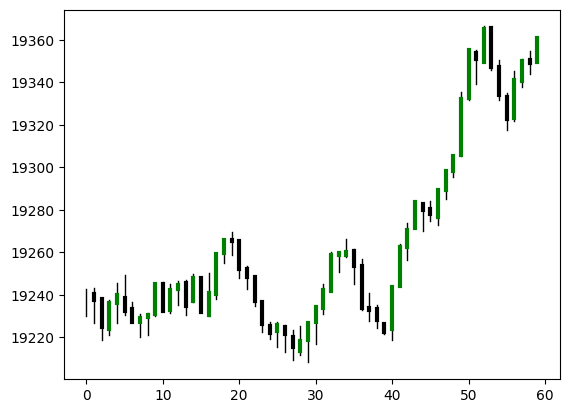

In [10]:
def plot_candles(candles):
    for index in range(len(candles)):
        candle = candles[index]
        c = "green" if candle.c > candle.o else "black"
        plt.plot([index, index], [candle.l, candle.h], linewidth=1, color = "black")
        plt.plot([index, index], [candle.c, candle.o], linewidth=3, color = c)
index+=1
#step(index)
plot_candles(m.m1_candles)
if(current_position.direction != 0):
    plt.axhline(current_position.entry, color = "g" if current_position.direction == 1 else "r")
    plt.axhline(current_position.sl, color = "orange")
    plt.axhline(current_position.tp, color = "orange")
if(current_order != None):
    plt.axhline(current_order.entry, color = "g" if current_order.direction == 1 else "r")
    plt.axhline(current_order.sl, color = "orange")
    plt.axhline(current_order.tp, color = "orange")
print(current_position.direction, equity_L[-1])

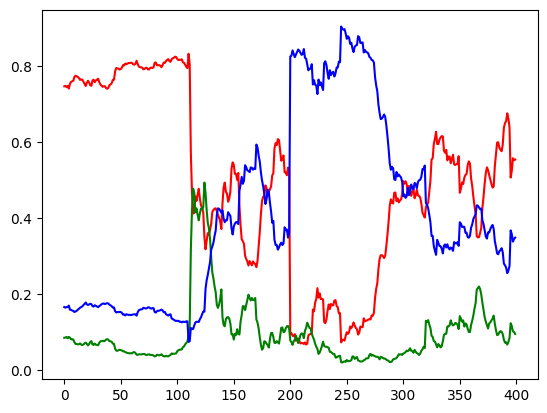

In [11]:
#plt.plot(outputs)
plt.plot([x[0] for x in outputs[-400:]], color="r")
plt.plot([x[1] for x in outputs[-400:]], color="g")
plt.plot([x[2] for x in outputs[-400:]], color="b")

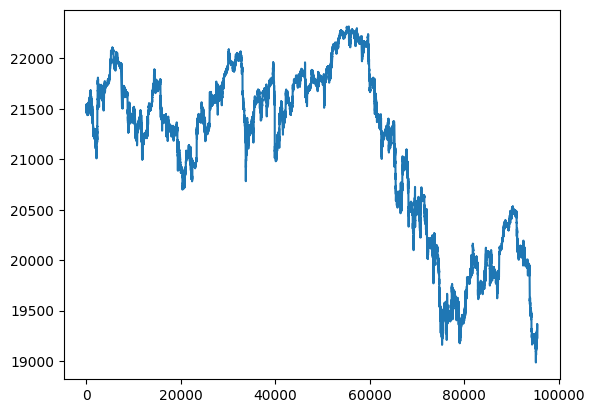

In [12]:
plt.plot([x.c for x in all_candles])

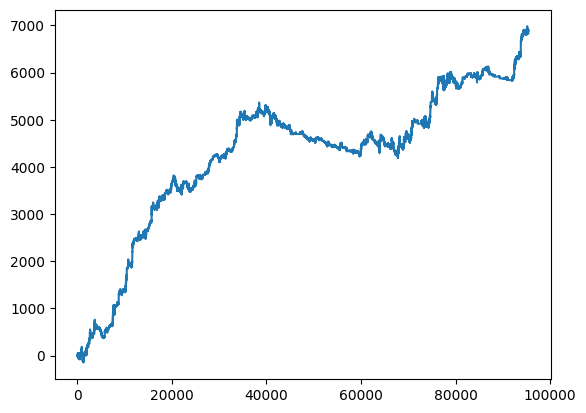

In [13]:
plt.plot(equity_L)

In [14]:
#plt.plot([x[1]-x[0] for x in outputs], color="b")